In [70]:
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
import re
import time
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import sys
print(sys.executable)

F:\Projtest\pjtest\Scripts\python.exe


In [85]:
# 시각화 한글폰트
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/handotum.ttf"  # Windows의 맑은 고딕 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [4]:
# Load the CSV file
# 기본 경로 지정
base_path = 'F:/cluster_test_2024/search_results_2024_06-04_combined'
filename = 'df_combined_search_results_uid-year-techfull_only.csv'
# 파일의 전체 경로
file_path = os.path.join(base_path, filename)
df_focal = pd.read_csv(file_path)
# Drop the unnamed column
df_focal = df_focal.drop(columns=['Unnamed: 0'])

In [5]:
# Get unique keys
keys = df_focal['key'].unique()
# Group by 'key' and 'pubyear', and count the unique 'uid' entries for each group
grouped_df = df_focal.groupby(['key', 'pubyear']).agg(uid_count=('uid', 'nunique')).reset_index()

In [6]:
df_focal

,uid,pubyear,key
0,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.)
1,WOS:000320972600005,2013,01. 금속 3D 프린팅(gpt_wo_abbr.)
2,WOS:000341631200006,2014,01. 금속 3D 프린팅(gpt_wo_abbr.)
3,WOS:000457238400006,2015,01. 금속 3D 프린팅(gpt_wo_abbr.)
4,WOS:000387298300030,2016,01. 금속 3D 프린팅(gpt_wo_abbr.)
...,...,...,...
602146,WOS:000477964600015,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602147,WOS:000483699900005,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602148,WOS:000469357900009,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602149,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.)


# reference 대용량 csv파일 불러오기 트릭
## - 샘플 확인하여 사용할 컬럼 확정

In [7]:
use_cols = ['uid', 'ref_count', 'ref_uid', 'ref_occurence_order','ref_year']

In [8]:
import time

chunksize = 100000000 # 1억 !!!
chunk_list = []  # append each chunk df here 

total_rows = 0
chunk_number = 0

In [9]:
start_time = time.time()
# Read the CSV file in chunks with tqdm progress bar
for chunk in pd.read_csv('F:\cluster_test_2024\wos2413db_pkls\combined_df_web_of_science_2413_raw_reference.csv', sep=',', usecols=use_cols, chunksize=chunksize):
    chunk_number += 1
    total_rows += len(chunk)
    chunk_list.append(chunk)
    
    elapsed_time = time.time() - start_time
    
    print(f"Chunk number: {chunk_number}, Elapsed time: {elapsed_time:.2f} seconds, Total rows: {total_rows}")

# Concatenate all chunks into one DataFrame (if needed)
df_refer = pd.concat(chunk_list)
#shape (1, 1594398232)

Chunk number: 1, Elapsed time: 105.22 seconds, Total rows: 100000000
Chunk number: 2, Elapsed time: 211.74 seconds, Total rows: 200000000
Chunk number: 3, Elapsed time: 322.82 seconds, Total rows: 300000000
Chunk number: 4, Elapsed time: 436.24 seconds, Total rows: 400000000
Chunk number: 5, Elapsed time: 551.25 seconds, Total rows: 500000000
Chunk number: 6, Elapsed time: 665.94 seconds, Total rows: 600000000
Chunk number: 7, Elapsed time: 781.12 seconds, Total rows: 700000000
Chunk number: 8, Elapsed time: 896.74 seconds, Total rows: 800000000
Chunk number: 9, Elapsed time: 1013.45 seconds, Total rows: 900000000
Chunk number: 10, Elapsed time: 1130.29 seconds, Total rows: 1000000000
Chunk number: 11, Elapsed time: 1246.52 seconds, Total rows: 1100000000
Chunk number: 12, Elapsed time: 1364.52 seconds, Total rows: 1200000000
Chunk number: 13, Elapsed time: 1482.47 seconds, Total rows: 1300000000
Chunk number: 14, Elapsed time: 1602.01 seconds, Total rows: 1400000000
Chunk number: 15, 

In [10]:
df_refer.shape

(1594398232, 5)

In [11]:
df_refer.columns = ['uid_citing', 'ref_count', 'ref_uid', 'ref_occurence_order', 'ref_year']

In [12]:
# 일반 pubyear 정보
df_pubinfo = pd.read_pickle('F:\cluster_test_2024\wos2413db_pkls\combined_df_web_of_science_2413_raw_pub_info_update23.pkl')
df_pub = df_pubinfo[['uid','pubyear']]

In [13]:
df_pub

,uid,pubyear
0,WOS:000241459500042,2006
1,WOS:000242098400054,2006
2,WOS:000244650603095,2006
3,WOS:000240512700001,2006
4,WOS:000240110700007,2006
...,...,...
51399255,WOS:001177396600002,2023
51399256,WOS:001168453600002,2023
51399257,WOS:001168232800015,2023
51399258,WOS:001168453600009,2023


In [14]:
# 전체 DI1지표 저장리스트
DI1_list = []
# 기술별연도별 그룹
grouped_focal = df_focal.groupby(['key', 'pubyear'])

In [15]:
# 한 그룹만 그룹으로 계산하자.

In [21]:
group = grouped_focal.get_group(('02. 신축성 전자소자', 2014))

In [22]:
focal_papers = set(group['uid'])

In [23]:
focal_references = set(df_refer[df_refer['uid_citing'].isin(focal_papers)]['ref_uid'])

In [25]:
set_cited_pool = focal_papers.union(focal_references)

In [26]:
len(set_cited_pool)

148191

In [27]:
set_citing_pool_allyear =set(df_refer[df_refer['ref_uid'].isin(set_cited_pool)]['uid_citing'])

In [28]:
df_citing_pool_allwithyear = df_pub[df_pub['uid'].isin(set_citing_pool_allyear)]

In [29]:
len(set_citing_pool_allyear)

10925853

In [49]:
set_citing_pool = set(df_citing_pool_allwithyear[df_citing_pool_allwithyear['pubyear']>2014]['uid'])

In [50]:
len(set_citing_pool)

6857278

In [51]:
df_citing_pool_refer = df_refer[df_refer['uid_citing'].isin(set_citing_pool)]

In [52]:
df_citing_pool_refer.shape

(374481024, 5)

In [53]:
len(focal_papers)

4681

In [54]:
len(focal_references)

144050

In [55]:
len(focal_papers.intersection(focal_references))

540

In [56]:
set_f = set(df_citing_pool_refer[df_citing_pool_refer['ref_uid'].isin(focal_papers)]['uid_citing'])

In [57]:
set_r = set(df_citing_pool_refer[df_citing_pool_refer['ref_uid'].isin(focal_references)]['uid_citing'])

In [58]:
len(set_f)

226955

In [59]:
len(set_r)

6843050

In [60]:
len(set_f.intersection(set_r))

212727

In [64]:
NF = len(set_f - set_r)

In [65]:
NRt0 = len(set_r - set_f)

In [66]:
NB = len(set_f.intersection(set_r))

In [67]:
# 그룹 DI1 통합지표 계산식
DI1 = (NF - NB) / (NF + NB + NRt0) if (NF + NB + NRt0) != 0 else 0

In [68]:
DI1

-0.028947200332260118

In [ ]:
# 그룹 계산 for문

# 전체 DI1지표 저장리스트
DI1_list = []

# 기술별연도별 그룹
grouped_focal = df_focal.groupby(['key', 'pubyear'])

In [74]:
# 그룹별 통합 DI1 지표 계산
print(f'Start!! current time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

for (key, year), group in tqdm(grouped_focal):
#    start_time = time.time()  # 시작 시간 기록

    focal_papers = set(group['uid'])
    focal_references = set(df_refer[df_refer['uid_citing'].isin(focal_papers)]['ref_uid'])
    set_cited_pool = focal_papers.union(focal_references)
    set_citing_pool_allyear =set(df_refer[df_refer['ref_uid'].isin(set_cited_pool)]['uid_citing'])
    df_citing_pool_allwithyear = df_pub[df_pub['uid'].isin(set_citing_pool_allyear)]
    set_citing_pool = set(df_citing_pool_allwithyear[df_citing_pool_allwithyear['pubyear']>2014]['uid'])
    df_citing_pool_refer = df_refer[df_refer['uid_citing'].isin(set_citing_pool)]
    set_f = set(df_citing_pool_refer[df_citing_pool_refer['ref_uid'].isin(focal_papers)]['uid_citing'])
    set_r = set(df_citing_pool_refer[df_citing_pool_refer['ref_uid'].isin(focal_references)]['uid_citing'])
    NF = len(set_f - set_r)
    NRt0 = len(set_r - set_f)
    NB = len(set_f.intersection(set_r))
    
    # 그룹 DI1 통합지표 계산식
    DI1 = (NF - NB) / (NF + NB + NRt0) if (NF + NB + NRt0) != 0 else 0

    # 기술별연도별 DI1 지표 저장
    DI1_list.append({'key':key, 'year':year, 'DI1':DI1})
    
    print(f'DI1: {DI1}, key:{key}, pubyear:{year}, no. of fps: {group.shape[0]}, current time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    
#    end_time = time.time()  # 종료 시간 기록
#    elapsed_time = end_time - start_time  # 소요 시간 계산
#    print(f'Time taken for {key}: {elapsed_time:.2f} seconds')

Start!! current time: 2024-07-23 16:05:10


  0%|          | 0/198 [00:00<?, ?it/s]

DI1: -0.005731685473759627, key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2006, no. of fps: 13, current time: 2024-07-23 16:08:41
DI1: -0.011567877629063097, key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2007, no. of fps: 11, current time: 2024-07-23 16:14:33
DI1: -0.00451767207015679, key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2008, no. of fps: 8, current time: 2024-07-23 16:18:08
DI1: 0.009193054136874362, key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2009, no. of fps: 9, current time: 2024-07-23 16:22:33
DI1: 0.036646307606885066, key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2010, no. of fps: 3, current time: 2024-07-23 16:25:48
DI1: 0.010039740640033466, key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2011, no. of fps: 3, current time: 2024-07-23 16:29:31
DI1: -0.01742034116511104, key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2012, no. of fps: 11, current time: 2024-07-23 16:34:43
DI1: -0.014911640134365415, key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2013, no. of fps: 23, current time: 2024-07-23 16:39:36
DI1: -0.0

In [75]:
DI1_list

[{'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2006),
  'DI1': -0.005731685473759627},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2007),
  'DI1': -0.011567877629063097},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2008),
  'DI1': -0.00451767207015679},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2009),
  'DI1': 0.009193054136874362},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2010),
  'DI1': 0.036646307606885066},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2011),
  'DI1': 0.010039740640033466},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2012),
  'DI1': -0.01742034116511104},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2013),
  'DI1': -0.014911640134365415},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2014),
  'DI1': -0.01209633869748353},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2015),
  'DI1': -0.016292513276831733},
 {'key': '01. 금속

In [76]:
df_DI1 = pd.DataFrame(DI1_list)

In [77]:
df_DI1

,key,year,DI1
0,01. 금속 3D 프린팅(gpt_wo_abbr.),2006,-0.005732
1,01. 금속 3D 프린팅(gpt_wo_abbr.),2007,-0.011568
2,01. 금속 3D 프린팅(gpt_wo_abbr.),2008,-0.004518
3,01. 금속 3D 프린팅(gpt_wo_abbr.),2009,0.009193
4,01. 금속 3D 프린팅(gpt_wo_abbr.),2010,0.036646
...,...,...,...
193,A1. 금속 3D 프린팅(largest_w_abbr.),2019,-0.005652
194,A1. 금속 3D 프린팅(largest_w_abbr.),2020,-0.004384
195,A1. 금속 3D 프린팅(largest_w_abbr.),2021,-0.003161
196,A1. 금속 3D 프린팅(largest_w_abbr.),2022,-0.001720


In [78]:
df_DI1.to_csv('df_top10_2018_metric_DI1.csv')

In [82]:
num_keys

NameError: name 'num_keys' is not defined

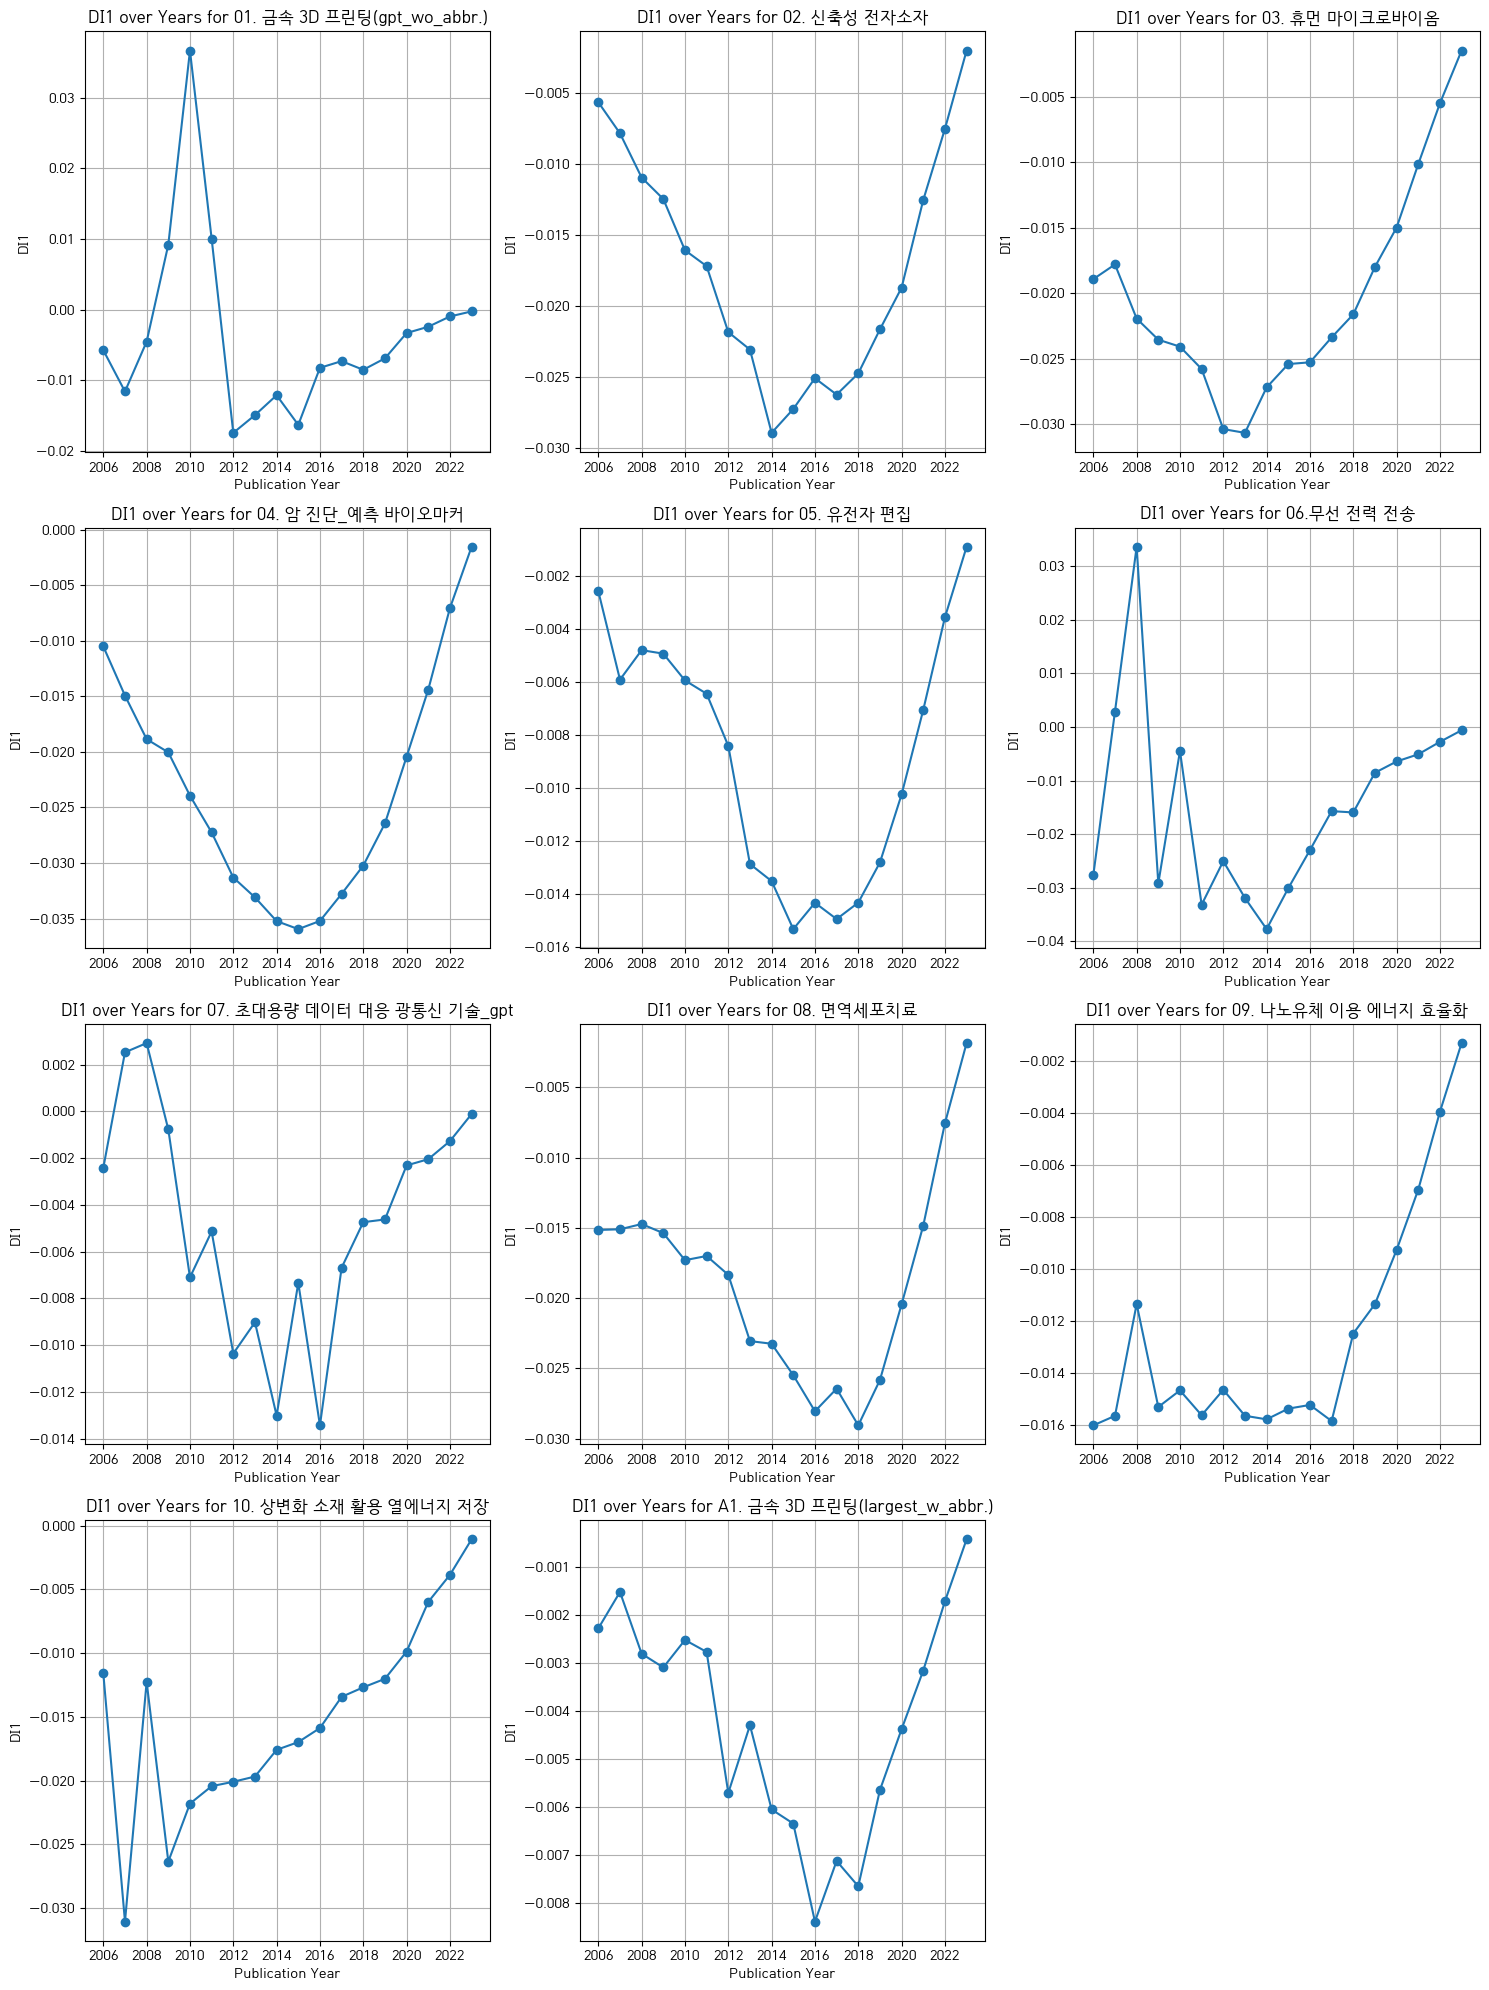

In [86]:
# 시각화
num_keys = len(keys)

fig, axes = plt.subplots(nrows=(num_keys + 2) // 3, ncols=3, figsize=(15, 5 * ((num_keys + 2) // 3)))

for i, key in enumerate(keys):
    ax = axes[i // 3, i % 3]
    subset = df_DI1[df_DI1['key'] == key]
    ax.plot(subset['year'], subset['DI1'], marker='o')
    ax.set_title(f'DI1 over Years for {key}')
    ax.set_xlabel('Publication Year')
    ax.set_ylabel('DI1')
    ax.grid(True)
    
    # x축 눈금을 2년 간격으로 설정
    years = subset['year'].astype(int)
    min_year = years.min()
    max_year = years.max()
    ax.set_xticks(range(min_year, max_year + 1, 2))
    ax.set_xticklabels(range(min_year, max_year + 1, 2))

# 마지막 사용되지 않는 서브플롯 비우기
if num_keys % 3 != 0:
    for j in range(num_keys, ((num_keys + 2) // 3) * 3):
        fig.delaxes(axes[j // 3, j % 3])

# 레이아웃 조정
plt.tight_layout()

# 파일로 저장
plt.savefig('disruption_index1_visualization.png', format='png')

# 그래프를 화면에 표시
plt.show()

In [14]:
from multiprocessing import Pool, cpu_count

In [15]:
# 개별 논문 DI1 지표 계산 함수 정의
def calculate_di1(fp):
    # fp의 레퍼런스
    f_refer = focal_refer[focal_refer['uid_citing'] == fp]
    f_refer_papers = list(set(f_refer['ref_uid']))
    
    cited_papers = f_refer_papers.copy()
    cited_papers.append(fp)
    
    # fp를 인용하는 문헌
    citing_fp = list(set(citing_focalwrefer[citing_focalwrefer['ref_uid'] == fp]['uid_citing']))
    
    # fp의 레퍼런스를 인용하는 이후 문헌 (pool로부터...)
    citing_fwrefer = citing_focalwrefer_tpool[citing_focalwrefer_tpool['ref_uid'].isin(f_refer_papers)]
    citing_fwrefer_papers = list(set(citing_fwrefer['uid_citing']))
    
    NRt0 = len(set(citing_fwrefer_papers) - set(citing_fp))
    NB = len(set(citing_fp).intersection(set(citing_fwrefer_papers)))
    NF = len(set(citing_fp) - set(citing_fwrefer_papers))

    # 개별 논문 DI1 지표 계산식
    DI1 = (NF - NB) / (NF + NB + NRt0) if (NF + NB + NRt0) != 0 else 0

    return {'uid': fp, 'DI1': DI1}

In [16]:
# 병렬 처리 함수
def parallel_calculate_di1(focal_papers, num_workers):
    start_time = time.time()
    with Pool(num_workers) as pool:
        results = []
        for result in tqdm(pool.imap_unordered(calculate_di1, focal_papers), total=len(focal_papers)):
            results.append(result)
            elapsed_time = time.time() - start_time
            progress = len(results) / len(focal_papers)
            remaining_time = (elapsed_time / progress) * (1 - progress)
            print(f"Progress: {progress:.2%}, Elapsed time: {elapsed_time:.2f}s, Remaining time: {remaining_time:.2f}s", end='\r')
    return results

In [17]:
# focal_papers의 레퍼런스 풀
focal_papers = df_focal['uid'].tolist()
focal_refer = df_refer[df_refer['uid_citing'].isin(focal_papers)]
focal_refer_papers = list(set(focal_refer['ref_uid']))
cited_papers_pool = focal_papers + focal_refer_papers

# cited_papers_pool의 인용 풀
citing_focalwrefer = df_refer[df_refer['ref_uid'].isin(cited_papers_pool)]
citing_focalwrefer_papers = list(set(citing_focalwrefer['uid_citing']))

# 이후 인용 풀 of cited_papers_pool
citing_focalwrefer_tpool = df_refer[df_refer['uid_citing'].isin(citing_focalwrefer_papers)]

In [ ]:
if __name__ == '__main__':
    num_workers = int(cpu_count() * 0.8)
    DI1_list = parallel_calculate_di1(focal_papers, num_workers)

  0%|          | 0/602151 [00:00<?, ?it/s]

In [ ]:
# 결과 출력
print(DI1_list)

In [137]:
# 초점 논문집합 논문 ID 리스트
focal_papers = df_focal['uid'].tolist()

In [139]:
len(focal_papers)

602151

In [204]:
df_focal

,uid,pubyear,key
0,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.)
1,WOS:000320972600005,2013,01. 금속 3D 프린팅(gpt_wo_abbr.)
2,WOS:000341631200006,2014,01. 금속 3D 프린팅(gpt_wo_abbr.)
3,WOS:000457238400006,2015,01. 금속 3D 프린팅(gpt_wo_abbr.)
4,WOS:000387298300030,2016,01. 금속 3D 프린팅(gpt_wo_abbr.)
...,...,...,...
602146,WOS:000477964600015,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602147,WOS:000483699900005,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602148,WOS:000469357900009,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602149,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.)


In [138]:
# 초점 논문집합(FP)을 인용한 논문 필터링
df_citing_after_fp = df_refer[df_refer['ref_uid'].isin(focal_papers)]

In [141]:
df_citing_after_fp

,uid_citing,ref_count,ref_uid,ref_occurence_order,ref_year
4012,WOS:000235283500017,30,WOS:000235283500024,15,2006
28358,WOS:000243137600019,22,WOS:000235041000006,22,2006
30138,WOS:000240537700013,32,WOS:000237828500021,29,2006
36247,WOS:000234575700001,17,WOS:000234575700003,1,2006
36248,WOS:000234575700001,17,WOS:000234575700006,6,2006
...,...,...,...,...,...
1594397375,WOS:001060921300001,13,WOS:000767175700003,9,2022
1594397376,WOS:001060921300001,13,WOS:000345478500009,7,2014
1594397379,WOS:001060921300001,13,WOS:000345199200008,6,2014
1594397636,WOS:001131480600001,131,WOS:000548042300001,57,2020


In [142]:
# 초점 논문집합(FP) 논문을 인용한 논문 정보(pubyear)
df_citing_info = df_citing_after_fp.merge(df_pub, left_on='uid_citing', right_on='uid')

In [143]:
df_citing_info.columns

Index(['uid_citing', 'ref_count', 'ref_uid', 'ref_occurence_order', 'ref_year',
       'uid', 'pubyear'],
      dtype='object')

In [145]:
df_citing_info.columns = ['uid_citing', 'ref_count', 'ref_uid', 'ref_occurence_order', 'ref_year',
       'uid', 'citing_pubyear']

In [146]:
df_citing_info

,uid_citing,ref_count,ref_uid,ref_occurence_order,ref_year,uid,citing_pubyear
0,WOS:000235283500017,30,WOS:000235283500024,15,2006,WOS:000235283500017,2006
1,WOS:000243137600019,22,WOS:000235041000006,22,2006,WOS:000243137600019,2006
2,WOS:000240537700013,32,WOS:000237828500021,29,2006,WOS:000240537700013,2006
3,WOS:000234575700001,17,WOS:000234575700003,1,2006,WOS:000234575700001,2006
4,WOS:000234575700001,17,WOS:000234575700006,6,2006,WOS:000234575700001,2006
...,...,...,...,...,...,...,...
18711437,WOS:001060921300001,13,WOS:000767175700003,9,2022,WOS:001060921300001,2023
18711438,WOS:001060921300001,13,WOS:000345478500009,7,2014,WOS:001060921300001,2023
18711439,WOS:001060921300001,13,WOS:000345199200008,6,2014,WOS:001060921300001,2023
18711440,WOS:001131480600001,131,WOS:000548042300001,57,2020,WOS:001131480600001,2023


In [156]:
# 초점 논문집합(FP)의 참고문헌 집합 (FP_R)
FP_R = df_refer[df_refer['uid_citing'].isin(focal_papers)]
list_FP_R = list(set(FP_R['ref_uid']))

In [154]:
len(list_FP_R)

9950546

In [153]:
# FP_R을 인용하는 논문 필터링 ->  set R+B
# (FP의 참고문헌 집합을 인용한 논문들이므로 FP를 동시에 인용했을 수도 아닐수도 있음. 
#  FP보다 출판연도가 늦을 수도 아닐수도 있음.)
#  현재 데이터프레임은 전체 레퍼런스 목록이 아닐 수 있음을 유의. -> 논문 번호 추출해서 전체 레퍼런스 목록 다시 받아야 함.
citing_papers_FP_RB = df_refer[df_refer['ref_uid'].isin(list_FP_R)]

In [191]:
# set R+B의 pubyear 붙여서, FP_pubyear보다 늦은 논문만 필터링 (이거 좀 이따가)
citing_papers_FP_RB_uid = list(citing_papers_FP_RB['uid_citing'].unique()) # 34563998 개 논문.

In [193]:
# 우선 FP 동시 인용 찾기. ->  set B 찾기.
big_RB = df_refer[df_refer['uid_citing'].isin(citing_papers_FP_RB_uid)]

In [194]:
big_RB.shape
# tooo big,....

(1447144602, 5)

In [196]:
# for 192 groups...
key=list(set(df_focal['key']))[0]


In [198]:
# for 192 groups...
pubyear=list(set(df_focal['pubyear']))[0]

In [199]:
pubyear

2016

In [176]:
### 논문 1개 실험하기.
# 초점 논문집합 논문 ID 리스트
# focal_papers = df_focal['uid'].tolist()
focal_p = focal_papers[0]
focal_p_uid = df_focal.iloc[0].uid
focal_p_pubyear = df_focal.iloc[0].pubyear
focal_p_key = df_focal.iloc[0].key

In [162]:
focal_Refers = FP_R[FP_R['uid_citing']==focal_p]

In [184]:
# FP_R
time1 = timeit.timeit("FP_R[FP_R['uid_citing']==focal_p]", globals=globals(), number=1)
print(f"FP_R (33853304) 탐색 실행 시간: {time1} 초")

FP_R (33853304) 탐색 실행 시간: 2.5746360000921413 초


In [185]:
# df_refer
time2 = timeit.timeit("df_refer[df_refer['uid_citing']==focal_p]", globals=globals(), number=1)
print(f"df_refer (1594398232) 탐색 실행 시간: {time1} 초")

df_refer (1594398232) 탐색 실행 시간: 2.5746360000921413 초


In [186]:
print(f"df_refer (1594398232) 탐색 실행 시간: {time2} 초")

df_refer (1594398232) 탐색 실행 시간: 107.1731702000834 초


In [182]:
df_refer.shape

(1594398232, 5)

In [183]:
FP_R.shape

(33853304, 5)

In [165]:
# 논문1의 레퍼런스
focal_p_references = (focal_Refers['ref_uid']).tolist()

In [167]:
# 논문1레퍼런스를 인용하는 set R+B
focal_p_RB = citing_papers_FP_RB[citing_papers_FP_RB['ref_uid'].isin(focal_p_references)]

In [170]:
# set R+B의 pubyear 매칭
focal_p_RB = focal_p_RB.merge(df_pub, left_on = 'uid_citing', right_on = 'uid', how = 'left')

In [177]:
focal_p_RB.shape

(21453, 7)

In [187]:
# set R+B의 focalpub 이후 논문만
focal_p_RB_later_t = focal_p_RB[focal_p_RB['pubyear'] >= focal_p_pubyear]

In [188]:
# set R과 set B 나누기. 초점논문 공동인용하는?
focal_p_RB_later_t[focal_p_RB_later_t['ref_uid']==focal_p_uid]

,uid_citing,ref_count,ref_uid,ref_occurence_order,ref_year,uid,pubyear


In [189]:
focal_p_RB_later_t

,uid_citing,ref_count,ref_uid,ref_occurence_order,ref_year,uid,pubyear
4103,WOS:000326135600036,32,WOS:000311350300026,14,2011,WOS:000326135600036,2013
4104,WOS:000316102300005,49,WOS:000311350300026,21,2011,WOS:000316102300005,2013
4105,WOS:000323968300025,12,WOS:000311350300026,10,2011,WOS:000323968300025,2013
4106,WOS:000322580800001,39,WOS:000311350300026,18,2011,WOS:000322580800001,2013
4107,WOS:000319329600004,60,WOS:000311350300026,28,2011,WOS:000319329600004,2013
...,...,...,...,...,...,...,...
21448,WOS:001042670700001,41,WOS:000311350300026,31,2011,WOS:001042670700001,2023
21449,WOS:000952946700006,72,WOS:000311350300026,37,2011,WOS:000952946700006,2023
21450,WOS:001031294200001,69,WOS:000255351500014,54,2008,WOS:001031294200001,2023
21451,WOS:000835175300001,80,WOS:000304338500003,66,2012,WOS:000835175300001,2023


In [190]:
focal_p_pubyear

np.int64(2013)

###### 

In [150]:
import timeit

# 첫 번째 줄 실행 시간 측정
time1 = timeit.timeit("df_refer[df_refer['uid_citing'].isin(focal_papers)]", globals=globals(), number=1)

# 두 번째 줄 실행 시간 측정
time2 = timeit.timeit("df_focal.merge(df_refer, left_on='uid', right_on='uid_citing', how='inner')", globals=globals(), number=1)

print(f"첫 번째 줄 실행 시간: {time1} 초")
print(f"두 번째 줄 실행 시간: {time2} 초")


첫 번째 줄 실행 시간: 79.29761090001557 초
두 번째 줄 실행 시간: 201.63354069995694 초


In [366]:
# 전체 DI1지표 저장리스트
DI1_list = []
# 기술별연도별 그룹
grouped_focal = df_focal.groupby(['key', 'pubyear'])

In [367]:
# 기술별 DI1 지표 계산
for (key, year), group in tqdm(grouped_focal):
    print(f'key:{key}, pubyear:{year}, no. of fps: {group.shape[0]}')

    # 기술별연도별 DI1 지표 저장리스트
    DI1_list_key_year = []
    
    focal_papers = group['uid'].tolist()
    
    # focal_papers의 레퍼런스pool
    focal_refer = df_refer[df_refer['uid_citing'].isin(focal_papers)]
    focal_refer_papers = list(set(focal_refer['ref_uid']))
    cited_papers_pool = focal_papers + focal_refer_papers
    
    # cited_papers_pool의 인용 pool
    citing_focalwrefer = df_refer[df_refer['ref_uid'].isin(cited_papers_pool)]
    citing_focalwrefer_papers = list(set(citing_focalwrefer['uid_citing']))
    
    # 이후인용 pool of cited_papers_pool
    citing_focalwrefer_papers_pub = df_pub[df_pub['uid'].isin(citing_focalwrefer_papers)]
    citing_focalwrefer_papers_tpool = citing_focalwrefer_papers_pub[citing_focalwrefer_papers_pub['pubyear']>=year]['uid'].tolist()
    
    citing_focalwrefer_tpool = df_refer[df_refer['uid_citing'].isin(citing_focalwrefer_papers_tpool)]
    
    # 개별논문 DI1 지표 계산
    for fp in focal_papers:
      
        # fp의 레퍼런스
        f_refer = focal_refer[focal_refer['uid_citing']==fp]
        f_refer_papers = list(set(f_refer['ref_uid']))
        
        cited_papers = f_refer_papers.copy()
        cited_papers.append(fp)
        
        # fp를 인용하는 문헌
        citing_fp = list(set(citing_focalwrefer[citing_focalwrefer['ref_uid']==fp]['uid_citing']))
        
        # fp의 레퍼런스를 인용하는 이후 문헌 (pool로부터...)
        citing_fwrefer = citing_focalwrefer_tpool[citing_focalwrefer_tpool['ref_uid'].isin(f_refer_papers)]
        citing_fwrefer_papers = list(set(citing_fwrefer['uid_citing']))
        
        NRt0 = len(set(citing_fwrefer_papers)-set(citing_fp))
        NB = len(set(citing_fp).intersection(set(citing_fwrefer_papers)))
        NF = len(set(citing_fp)-set(citing_fwrefer_papers))

        # 개별논문 DI1 지표 계산식
        DI1 = (NF - NB) / (NF + NB + NRt0) if (NF + NB + NRt0) != 0 else 0

        # 개별논문 DI1 지표 저장
        DI1_list_key_year.append({'uid': fp, 'DI1': DI1})
    
    # 기술별연도별 DI1 지표 저장
    DI1_list.append({'key':key, 'year':year, 'DI1_list_key_year':DI1_list_key_year})

  0%|          | 0/198 [00:00<?, ?it/s]

key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2006, no. of fps: 13
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2007, no. of fps: 11
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2008, no. of fps: 8
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2009, no. of fps: 9
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2010, no. of fps: 3
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2011, no. of fps: 3
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2012, no. of fps: 11
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2013, no. of fps: 23
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2014, no. of fps: 20
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2015, no. of fps: 34
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2016, no. of fps: 70
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2017, no. of fps: 98
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2018, no. of fps: 146
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2019, no. of fps: 150
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2020, no. of fps: 166
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2021, no. of fps: 191
key:01. 

KeyboardInterrupt: 

In [368]:
DI1_list

[{'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2006),
  'DI1_list_key_year': [{'uid': 'WOS:000242551600006',
    'DI1': 0.0031961646024770275},
   {'uid': 'WOS:000241683200007', 'DI1': -0.006334841628959276},
   {'uid': 'WOS:000234519300006', 'DI1': 0.05736137667304015},
   {'uid': 'WOS:000242911200009', 'DI1': -0.006498781478472786},
   {'uid': 'WOS:000241457400035', 'DI1': -0.0016012810248198558},
   {'uid': 'WOS:000242469000052', 'DI1': 0.006578947368421052},
   {'uid': 'WOS:000238056400298', 'DI1': 0.004524886877828055},
   {'uid': 'WOS:000238056400300', 'DI1': 1.0},
   {'uid': 'WOS:000239874800031', 'DI1': 0.018973998594518624},
   {'uid': 'WOS:000240257800007', 'DI1': -0.0006670224119530416},
   {'uid': 'WOS:000238426200005', 'DI1': 0.040983606557377046},
   {'uid': 'WOS:000243161200004', 'DI1': 0.05263157894736842},
   {'uid': 'WOS:000235379700011', 'DI1': -0.01}]},
 {'key': '01. 금속 3D 프린팅(gpt_wo_abbr.)',
  'year': np.int64(2007),
  'DI1_list_key_year': [{'uid': 'WOS

In [370]:
!pip install joblib

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


In [371]:
from joblib import Parallel, delayed

In [372]:
def calculate_DI1_for_fp(fp, focal_refer, citing_focalwrefer, citing_focalwrefer_tpool):
    # fp의 레퍼런스
    f_refer = focal_refer[focal_refer['uid_citing'] == fp]
    f_refer_papers = set(f_refer['ref_uid'])

    cited_papers = f_refer_papers.copy()
    cited_papers.add(fp)

    # fp를 인용하는 문헌
    citing_fp = set(citing_focalwrefer[citing_focalwrefer['ref_uid'] == fp]['uid_citing'])

    # fp의 레퍼런스를 인용하는 이후 문헌
    citing_fwrefer = citing_focalwrefer_tpool[citing_focalwrefer_tpool['ref_uid'].isin(f_refer_papers)]
    citing_fwrefer_papers = set(citing_fwrefer['uid_citing'])

    NRt0 = len(citing_fwrefer_papers - citing_fp)
    NB = len(citing_fp & citing_fwrefer_papers)
    NF = len(citing_fp - citing_fwrefer_papers)

    # 개별논문 DI1 지표 계산식
    DI1 = (NF - NB) / (NF + NB + NRt0) if (NF + NB + NRt0) != 0 else 0

    return {'uid': fp, 'DI1': DI1}

In [373]:
# 기술별 DI1 지표 계산
DI1_list = []

for (key, year), group in tqdm(grouped_focal):
    print(f'key:{key}, pubyear:{year}, no. of fps: {group.shape[0]}')

    # focal_papers 및 focal_refer 미리 계산
    focal_papers = group['uid'].tolist()
    focal_refer = df_refer[df_refer['uid_citing'].isin(focal_papers)]
    focal_refer_papers = set(focal_refer['ref_uid'])
    cited_papers_pool = set(focal_papers) | focal_refer_papers

    # citing_focalwrefer 및 citing_focalwrefer_tpool 미리 계산
    citing_focalwrefer = df_refer[df_refer['ref_uid'].isin(cited_papers_pool)]
    citing_focalwrefer_papers = set(citing_focalwrefer['uid_citing'])
    citing_focalwrefer_papers_pub = df_pub[df_pub['uid'].isin(citing_focalwrefer_papers)]
    citing_focalwrefer_papers_tpool = citing_focalwrefer_papers_pub[citing_focalwrefer_papers_pub['pubyear'] >= year]['uid'].tolist()
    citing_focalwrefer_tpool = df_refer[df_refer['uid_citing'].isin(citing_focalwrefer_papers_tpool)]

    # 병렬 처리로 개별 논문 DI1 지표 계산
    DI1_list_key_year = Parallel(n_jobs=10)(
        delayed(calculate_DI1_for_fp)(fp, focal_refer, citing_focalwrefer, citing_focalwrefer_tpool)
        for fp in focal_papers
    )

    # 기술별연도별 DI1 지표 저장
    DI1_list.append({'key': key, 'year': year, 'DI1_list_key_year': DI1_list_key_year})

# 결과 저장

  0%|          | 0/198 [00:00<?, ?it/s]

key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2006, no. of fps: 13
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2007, no. of fps: 11


F:\Projtest\pjtest\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2008, no. of fps: 8


KeyboardInterrupt: 

In [374]:
def calculate_DI1_for_fp(fp, focal_refer, citing_focalwrefer, citing_focalwrefer_tpool):
    # fp의 레퍼런스
    f_refer = focal_refer[focal_refer['uid_citing'] == fp]
    f_refer_papers = set(f_refer['ref_uid'])

    cited_papers = f_refer_papers.copy()
    cited_papers.add(fp)

    # fp를 인용하는 문헌
    citing_fp = set(citing_focalwrefer[citing_focalwrefer['ref_uid'] == fp]['uid_citing'])

    # fp의 레퍼런스를 인용하는 이후 문헌
    citing_fwrefer = citing_focalwrefer_tpool[citing_focalwrefer_tpool['ref_uid'].isin(f_refer_papers)]
    citing_fwrefer_papers = set(citing_fwrefer['uid_citing'])

    NRt0 = len(citing_fwrefer_papers - citing_fp)
    NB = len(citing_fp & citing_fwrefer_papers)
    NF = len(citing_fp - citing_fwrefer_papers)

    # 개별논문 DI1 지표 계산식
    DI1 = (NF - NB) / (NF + NB + NRt0) if (NF + NB + NRt0) != 0 else 0

    return {'uid': fp, 'DI1': DI1}

def process_group(group, key, year, df_refer_shards, df_pub):
    # focal_papers 및 focal_refer 미리 계산
    focal_papers = group['uid'].tolist()
    focal_refer = pd.concat([shard[shard['uid_citing'].isin(focal_papers)] for shard in df_refer_shards])
    focal_refer_papers = set(focal_refer['ref_uid'])
    cited_papers_pool = set(focal_papers) | focal_refer_papers

    # citing_focalwrefer 및 citing_focalwrefer_tpool 미리 계산
    citing_focalwrefer = pd.concat([shard[shard['ref_uid'].isin(cited_papers_pool)] for shard in df_refer_shards])
    citing_focalwrefer_papers = set(citing_focalwrefer['uid_citing'])
    citing_focalwrefer_papers_pub = df_pub[df_pub['uid'].isin(citing_focalwrefer_papers)]
    citing_focalwrefer_papers_tpool = citing_focalwrefer_papers_pub[citing_focalwrefer_papers_pub['pubyear'] >= year]['uid'].tolist()
    citing_focalwrefer_tpool = pd.concat([shard[shard['uid_citing'].isin(citing_focalwrefer_papers_tpool)] for shard in df_refer_shards])

    # 병렬 처리로 개별 논문 DI1 지표 계산
    DI1_list_key_year = Parallel(n_jobs=10, timeout=300)(
        delayed(calculate_DI1_for_fp)(fp, focal_refer, citing_focalwrefer, citing_focalwrefer_tpool)
        for fp in focal_papers
    )

    return {'key': key, 'year': year, 'DI1_list_key_year': DI1_list_key_year}

def shard_dataframe(df, num_shards):
    shard_size = len(df) // num_shards
    return [df[i*shard_size:(i+1)*shard_size] for i in range(num_shards)]

# 데이터프레임 샤딩
num_shards = 10
df_refer_shards = shard_dataframe(df_refer, num_shards)

# 기술별 DI1 지표 계산
DI1_list = []

for (key, year), group in tqdm(grouped_focal):
    print(f'key:{key}, pubyear:{year}, no. of fps: {group.shape[0]}')

    result = process_group(group, key, year, df_refer_shards, df_pub)
    DI1_list.append(result)

# 결과 저장


  0%|          | 0/198 [00:00<?, ?it/s]

key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2006, no. of fps: 13
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2007, no. of fps: 11
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2008, no. of fps: 8
key:01. 금속 3D 프린팅(gpt_wo_abbr.), pubyear:2009, no. of fps: 9


KeyboardInterrupt: 

In [14]:
from datetime import datetime

In [29]:
from joblib import Parallel, delayed

In [15]:
org_df_focal = df_focal

In [24]:
df_focal = df_focal[df_focal['key']!='01. 금속 3D 프린팅(gpt_wo_abbr.)']

In [25]:
df_focal = df_focal[df_focal['pubyear']>2013]

In [26]:
df_focal

,uid,pubyear,key
1474,WOS:000338662100025,2014,02. 신축성 전자소자
1475,WOS:000331910200015,2014,02. 신축성 전자소자
1476,WOS:000339218600011,2014,02. 신축성 전자소자
1477,WOS:000332029100016,2014,02. 신축성 전자소자
1478,WOS:000337490600012,2014,02. 신축성 전자소자
...,...,...,...
602146,WOS:000477964600015,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602147,WOS:000483699900005,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602148,WOS:000469357900009,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602149,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.)


In [27]:
# 전체 DI1지표 저장리스트
DI1_list = []
# 기술별연도별 그룹
grouped_focal = df_focal.groupby(['key', 'pubyear'])

In [ ]:
def calculate_DI1_for_fp(fp, focal_refer, citing_focalwrefer, citing_focalwrefer_tpool):
    # fp의 레퍼런스
    f_refer = focal_refer[focal_refer['uid_citing'] == fp]
    f_refer_papers = set(f_refer['ref_uid'])

    cited_papers = f_refer_papers.copy()
    cited_papers.add(fp)

    # fp를 인용하는 문헌
    citing_fp = set(citing_focalwrefer[citing_focalwrefer['ref_uid'] == fp]['uid_citing'])

    # fp의 레퍼런스를 인용하는 이후 문헌
    citing_fwrefer = citing_focalwrefer_tpool[citing_focalwrefer_tpool['ref_uid'].isin(f_refer_papers)]
    citing_fwrefer_papers = set(citing_fwrefer['uid_citing'])

    NRt0 = len(citing_fwrefer_papers - citing_fp)
    NB = len(citing_fp & citing_fwrefer_papers)
    NF = len(citing_fp - citing_fwrefer_papers)

    # 개별논문 DI1 지표 계산식
    DI1 = (NF - NB) / (NF + NB + NRt0) if (NF + NB + NRt0) != 0 else 0

    return {'uid': fp, 'DI1': DI1}

def process_group(group, key, year, df_refer_shards, df_pub):
    # focal_papers 및 focal_refer 미리 계산
    focal_papers = group['uid'].tolist()
    focal_refer = pd.concat([shard[shard['uid_citing'].isin(focal_papers)] for shard in df_refer_shards])
    focal_refer_papers = set(focal_refer['ref_uid'])
    cited_papers_pool = set(focal_papers) | focal_refer_papers

    # citing_focalwrefer 및 citing_focalwrefer_tpool 미리 계산
    citing_focalwrefer = pd.concat([shard[shard['ref_uid'].isin(cited_papers_pool)] for shard in df_refer_shards])
    citing_focalwrefer_papers = set(citing_focalwrefer['uid_citing'])
    citing_focalwrefer_papers_pub = df_pub[df_pub['uid'].isin(citing_focalwrefer_papers)]
    citing_focalwrefer_papers_tpool = citing_focalwrefer_papers_pub[citing_focalwrefer_papers_pub['pubyear'] >= year]['uid'].tolist()
    citing_focalwrefer_tpool = pd.concat([shard[shard['uid_citing'].isin(citing_focalwrefer_papers_tpool)] for shard in df_refer_shards])

    # 병렬 처리로 개별 논문 DI1 지표 계산
    DI1_list_key_year = Parallel(n_jobs=16, timeout=300)(
        delayed(calculate_DI1_for_fp)(fp, focal_refer, citing_focalwrefer, citing_focalwrefer_tpool)
        for fp in focal_papers
    )

    return {'key': key, 'year': year, 'DI1_list_key_year': DI1_list_key_year}

# 데이터프레임 샤딩 함수            
def shard_dataframe(df, num_shards):
    shard_size = len(df) // num_shards
    return [df[i*shard_size:(i+1)*shard_size] for i in range(num_shards)]

# 데이터프레임 샤딩
num_shards = 10
df_refer_shards = shard_dataframe(df_refer, num_shards)

In [33]:
# 기술별 DI1 지표 계산
DI1_list = []

for (key, year), group in tqdm(grouped_focal):
    print(f'key:{key}, pubyear:{year}, no. of fps: {group.shape[0]}, current time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

    result = process_group(group, key, year, df_refer_shards, df_pub)
    DI1_list.append(result)

# 결과 저장

  0%|          | 0/100 [00:00<?, ?it/s]

key:02. 신축성 전자소자, pubyear:2014, no. of fps: 4681, current time: 2024-07-22 17:21:34


F:\Projtest\pjtest\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


TimeoutError: 

In [36]:
df_focal

,uid,pubyear,key
1474,WOS:000338662100025,2014,02. 신축성 전자소자
1475,WOS:000331910200015,2014,02. 신축성 전자소자
1476,WOS:000339218600011,2014,02. 신축성 전자소자
1477,WOS:000332029100016,2014,02. 신축성 전자소자
1478,WOS:000337490600012,2014,02. 신축성 전자소자
...,...,...,...
602146,WOS:000477964600015,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602147,WOS:000483699900005,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602148,WOS:000469357900009,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602149,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.)


In [ ]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool

def calculate_DI1(fp, citing_focalwrefer, citing_focalwrefer_tpool, focal_refer):
    # fp의 레퍼런스
    f_refer = focal_refer[focal_refer['uid_citing'] == fp]
    f_refer_papers = list(set(f_refer['ref_uid']))
    
    cited_papers = f_refer_papers.copy()
    cited_papers.append(fp)
    
    # fp를 인용하는 문헌
    citing_fp = list(set(citing_focalwrefer[citing_focalwrefer['ref_uid'] == fp]['uid_citing']))
    
    # fp의 레퍼런스를 인용하는 이후 문헌 (pool로부터...)
    citing_fwrefer = citing_focalwrefer_tpool[citing_focalwrefer_tpool['ref_uid'].isin(f_refer_papers)]
    citing_fwrefer_papers = list(set(citing_fwrefer['uid_citing']))
    
    NRt0 = len(set(citing_fwrefer_papers) - set(citing_fp))
    NB = len(set(citing_fp).intersection(set(citing_fwrefer_papers)))
    NF = len(set(citing_fp) - set(citing_fwrefer_papers))

    # 개별논문 DI1 지표 계산식
    DI1 = (NF - NB) / (NF + NB + NRt0) if (NF + NB + NRt0) != 0 else 0
    return {'uid': fp, 'DI1': DI1}

def process_group(key_year_group):
    (key, year), group = key_year_group
    print(f'key:{key}, pubyear:{year}, no. of fps: {group.shape[0]}')

    # 기술별연도별 DI1 지표 저장리스트
    DI1_list_key_year = []
    
    focal_papers = group['uid'].tolist()
    
    # focal_papers의 레퍼런스pool
    focal_refer = df_refer[df_refer['uid_citing'].isin(focal_papers)]
    focal_refer_papers = list(set(focal_refer['ref_uid']))
    cited_papers_pool = focal_papers + focal_refer_papers
    
    # cited_papers_pool의 인용 pool
    citing_focalwrefer = df_refer[df_refer['ref_uid'].isin(cited_papers_pool)]
    citing_focalwrefer_papers = list(set(citing_focalwrefer['uid_citing']))
    
    # 이후인용 pool of cited_papers_pool
    citing_focalwrefer_papers_pub = df_pub[df_pub['uid'].isin(citing_focalwrefer_papers)]
    citing_focalwrefer_papers_tpool = citing_focalwrefer_papers_pub[citing_focalwrefer_papers_pub['pubyear'] >= year]['uid'].tolist()
    
    citing_focalwrefer_tpool = df_refer[df_refer['uid_citing'].isin(citing_focalwrefer_papers_tpool)]
    
    with Pool() as pool:
        results = pool.starmap(calculate_DI1, [(fp, citing_focalwrefer, citing_focalwrefer_tpool, focal_refer) for fp in focal_papers])
    
    DI1_list_key_year.extend(results)
    
    return {'key': key, 'year': year, 'DI1_list_key_year': DI1_list_key_year}

# 기술별 DI1 지표 계산
DI1_list = []
grouped_focal = df_focal.groupby(['key', 'pubyear'])

for key_year_group in tqdm(grouped_focal):
    DI1_list.append(process_group(key_year_group))

# 결과 출력
print(DI1_list)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

key:02. 신축성 전자소자, pubyear:2014, no. of fps: 4681


In [349]:
df_di1 = pd.DataFrame(DI1_list)

Mean DI1: 0.041729591320876426
Median DI1: 0.00044583147570218456
Standard Deviation DI1: 0.19266823934702826
25th, 50th (Median), 75th Percentiles DI1: [-0.0063265   0.00044583  0.00800339]


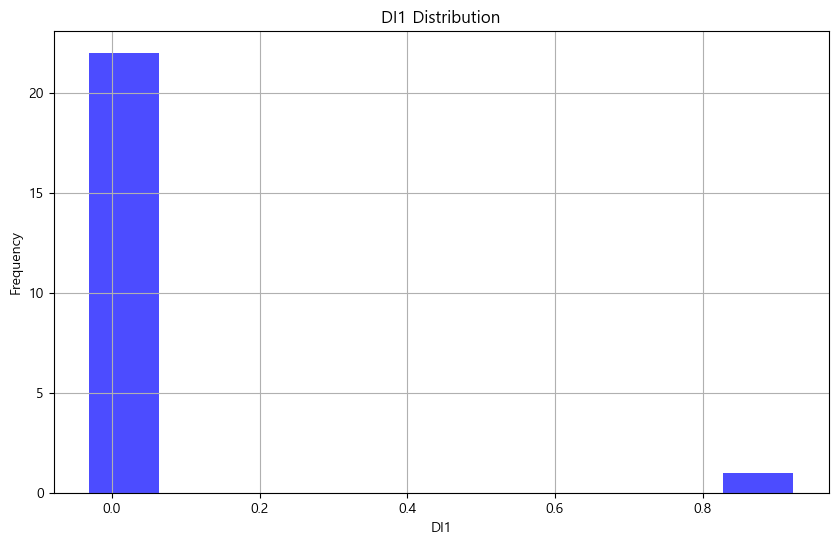

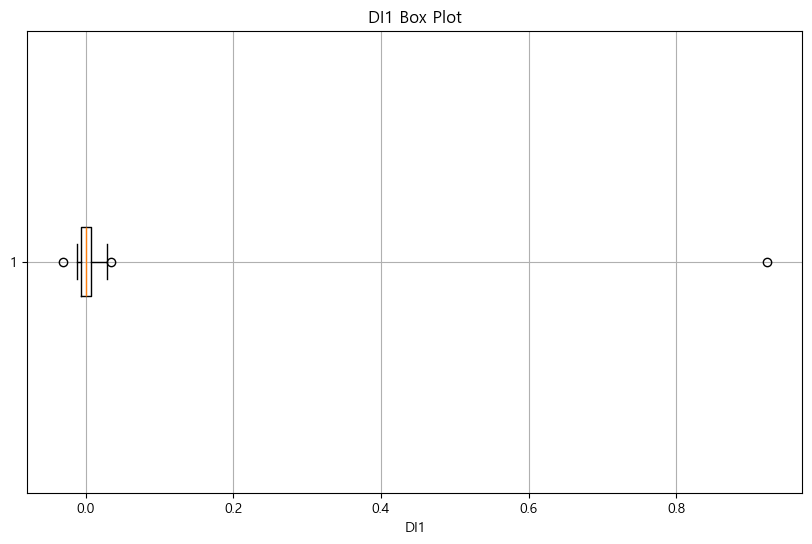

In [350]:
# 통계값 계산
mean_di1 = df_di1['DI1'].mean()
median_di1 = df_di1['DI1'].median()
std_di1 = df_di1['DI1'].std()
percentiles_di1 = np.percentile(df_di1['DI1'], [25, 50, 75])

# 결과 출력
print(f"Mean DI1: {mean_di1}")
print(f"Median DI1: {median_di1}")
print(f"Standard Deviation DI1: {std_di1}")
print(f"25th, 50th (Median), 75th Percentiles DI1: {percentiles_di1}")

# 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(df_di1['DI1'], bins=10, alpha=0.7, color='blue')
plt.title('DI1 Distribution')
plt.xlabel('DI1')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(df_di1['DI1'], vert=False)
plt.title('DI1 Box Plot')
plt.xlabel('DI1')
plt.grid(True)
plt.show()

In [280]:
citing_focalwrefer_tpool.shape

(4721227, 5)

In [281]:
citing_focalwrefer.shape

(137120, 5)

In [282]:
len(citing_focalwrefer_papers)

103108

In [283]:
len(citing_focalwrefer_papers_tpool)

79455

In [148]:
for (key, year), group in tqdm(grouped_focal):
    focal_papers_year_key = group['uid']
    citing_papers = df_citing_info[df_citing_info['ref_uid'].isin(focal_papers_year_key)]
    
    nf = len(citing_papers[~citing_papers['uid_citing'].isin(focal_papers_year_key)])
    nb = len(citing_papers[citing_papers['uid_citing'].isin(focal_papers_year_key)])
    
    all_citations = df_refer[df_refer['ref_uid'].isin(focal_papers_year_key)]
    nr = len(all_citations[~all_citations['uid_citing'].isin(focal_papers_year_key)])
    
    di1 = (nf - nb) / (nf + nb + nr) if (nf + nb + nr) != 0 else 0
    di1_results.append({'key': key, 'year': year, 'DI1': di1})

  0%|          | 0/198 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df_di1 = pd.DataFrame(di1_results)

In [ ]:
# 기술별 DI1 지표의 연도별 변화를 그래프로 출력
keys = df_di1['key'].unique()
fig, axes = plt.subplots(1, len(keys), figsize=(15, 5), sharey=True)

for i, key in enumerate(keys):
    ax = axes[i]
    data = df_di1[df_di1['key'] == key]
    ax.plot(data['year'], data['DI1'], marker='o')
    ax.set_title(f'DI1 over Years for {key}')
    ax.set_xlabel('Year')
    ax.set_ylabel('DI1')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [135]:
df_pub = df_pubinfo[['uid','pubyear']]

In [51]:
# df_pub과 df를 병합하여 출판 연도와 key 정보를 추가 (inner join)
df_merged = df_pub.merge(df, left_on=['uid', 'pubyear'], right_on=['ref_uid', 'ref_year'], how='inner')

In [52]:
df_merged.columns

Index(['uid', 'pubyear', 'key', 'uid_citing', 'ref_count', 'ref_uid',
       'ref_occurence_order', 'ref_year'],
      dtype='object')

In [53]:
# df_merged와 df_citing_pub을 병합하여 인용 연도를 추가
df_merged = df_merged.merge(df_citing_pub, on='uid_citing', how='left')

In [54]:
# 출판 연도와 인용 연도 차이를 계산하여 새로운 컬럼 생성
df_merged['citation_lag'] = df_merged['pubyear_citing'] - df_merged['ref_year']

In [117]:
# 첫 인용까지 걸린 기간 계산
df_merged['time_to_first_citation'] = df_merged['pubyear_citing'] - df_merged['pubyear']
df_merged['time_to_first_citation'] = df_merged['time_to_first_citation'].apply(lambda x: max(x, 0))

# 첫 인용까지 걸린 기간 중 최솟값만 사용
df_first_cite = df_merged.groupby('uid').agg({'time_to_first_citation': 'min'}).reset_index()

# 병합을 통해 다른 정보 유지
df_first_cite = pd.merge(df_first_cite, df_pub, on='uid', how='inner')
df_first_cite

,uid,time_to_first_citation,pubyear,key
0,WOS:000202946800014,0,2007,04. 암 진단_예측 바이오마커
1,WOS:000202981600002,1,2006,04. 암 진단_예측 바이오마커
2,WOS:000202981600011,1,2006,04. 암 진단_예측 바이오마커
3,WOS:000202981700010,0,2006,04. 암 진단_예측 바이오마커
4,WOS:000202981700012,1,2006,04. 암 진단_예측 바이오마커
...,...,...,...,...
536624,WOS:001184860900001,0,2023,03. 휴먼 마이크로바이옴
536625,WOS:001187299700013,0,2023,09. 나노유체 이용 에너지 효율화
536626,WOS:001187367500001,1,2022,03. 휴먼 마이크로바이옴
536627,WOS:001187419100001,1,2022,05. 유전자 편집


In [98]:
df_merged.shape

(19220039, 11)

In [118]:
df_first_cite.shape

(536629, 4)

In [99]:
df_merged

,uid,pubyear,key,uid_citing,ref_count,ref_uid,ref_occurence_order,ref_year,pubyear_citing,citation_lag,time_to_first_citation
0,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.),WOS:000325946800022,31,WOS:000327686700011,15,2013,2013,0,0
1,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.),WOS:000379449000044,53,WOS:000327686700011,25,2013,2014,1,1
2,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.),WOS:000337490600012,45,WOS:000327686700011,20,2013,2014,1,1
3,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.),WOS:000345553000069,53,WOS:000327686700011,22,2013,2014,1,1
4,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.),WOS:000341020700004,67,WOS:000327686700011,41,2013,2014,1,1
...,...,...,...,...,...,...,...,...,...,...,...
19220034,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.),WOS:000885262000003,42,WOS:000754604800030,15,2021,2022,1,1
19220035,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.),WOS:000869102200002,30,WOS:000754604800030,9,2021,2022,1,1
19220036,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.),WOS:000967607900007,41,WOS:000754604800030,25,2021,2023,2,2
19220037,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.),WOS:000956177500024,29,WOS:000754604800030,3,2021,2023,2,2


In [121]:
# 그룹화 및 f0~f4 계산
def calculate_f_values(group):
    f_values = {}
    total_papers = len(group)
    for i in range(5):
        f_values[f'f{i}'] = len(group[group['time_to_first_citation'] == i]) / total_papers
    return pd.Series(f_values)

In [122]:
grouped = df_first_cite.groupby(['key', 'pubyear']).apply(calculate_f_values).reset_index()

C:\Users\skim\AppData\Local\Temp\ipykernel_3048\3973524010.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_first_cite.groupby(['key', 'pubyear']).apply(calculate_f_values).reset_index()


In [123]:
grouped

,key,pubyear,f0,f1,f2,f3,f4
0,01. 금속 3D 프린팅(gpt_wo_abbr.),2006,0.384615,0.153846,0.230769,0.000000,0.000000
1,01. 금속 3D 프린팅(gpt_wo_abbr.),2007,0.636364,0.090909,0.090909,0.090909,0.000000
2,01. 금속 3D 프린팅(gpt_wo_abbr.),2008,0.125000,0.625000,0.125000,0.000000,0.000000
3,01. 금속 3D 프린팅(gpt_wo_abbr.),2009,0.000000,0.333333,0.333333,0.222222,0.000000
4,01. 금속 3D 프린팅(gpt_wo_abbr.),2010,0.000000,0.666667,0.333333,0.000000,0.000000
...,...,...,...,...,...,...,...
193,A1. 금속 3D 프린팅(largest_w_abbr.),2019,0.435897,0.462423,0.079576,0.013263,0.008842
194,A1. 금속 3D 프린팅(largest_w_abbr.),2020,0.467477,0.450322,0.064332,0.017870,0.000000
195,A1. 금속 3D 프린팅(largest_w_abbr.),2021,0.499074,0.423101,0.077826,0.000000,0.000000
196,A1. 금속 3D 프린팅(largest_w_abbr.),2022,0.573790,0.426210,0.000000,0.000000,0.000000


In [124]:
# CS 지표 계산
grouped['CS'] = -np.log(
    grouped['f0'] + grouped['f1']*np.exp(-1) + grouped['f2']*np.exp(-2) + grouped['f3']*np.exp(-3) + grouped['f4']*np.exp(-4)
)

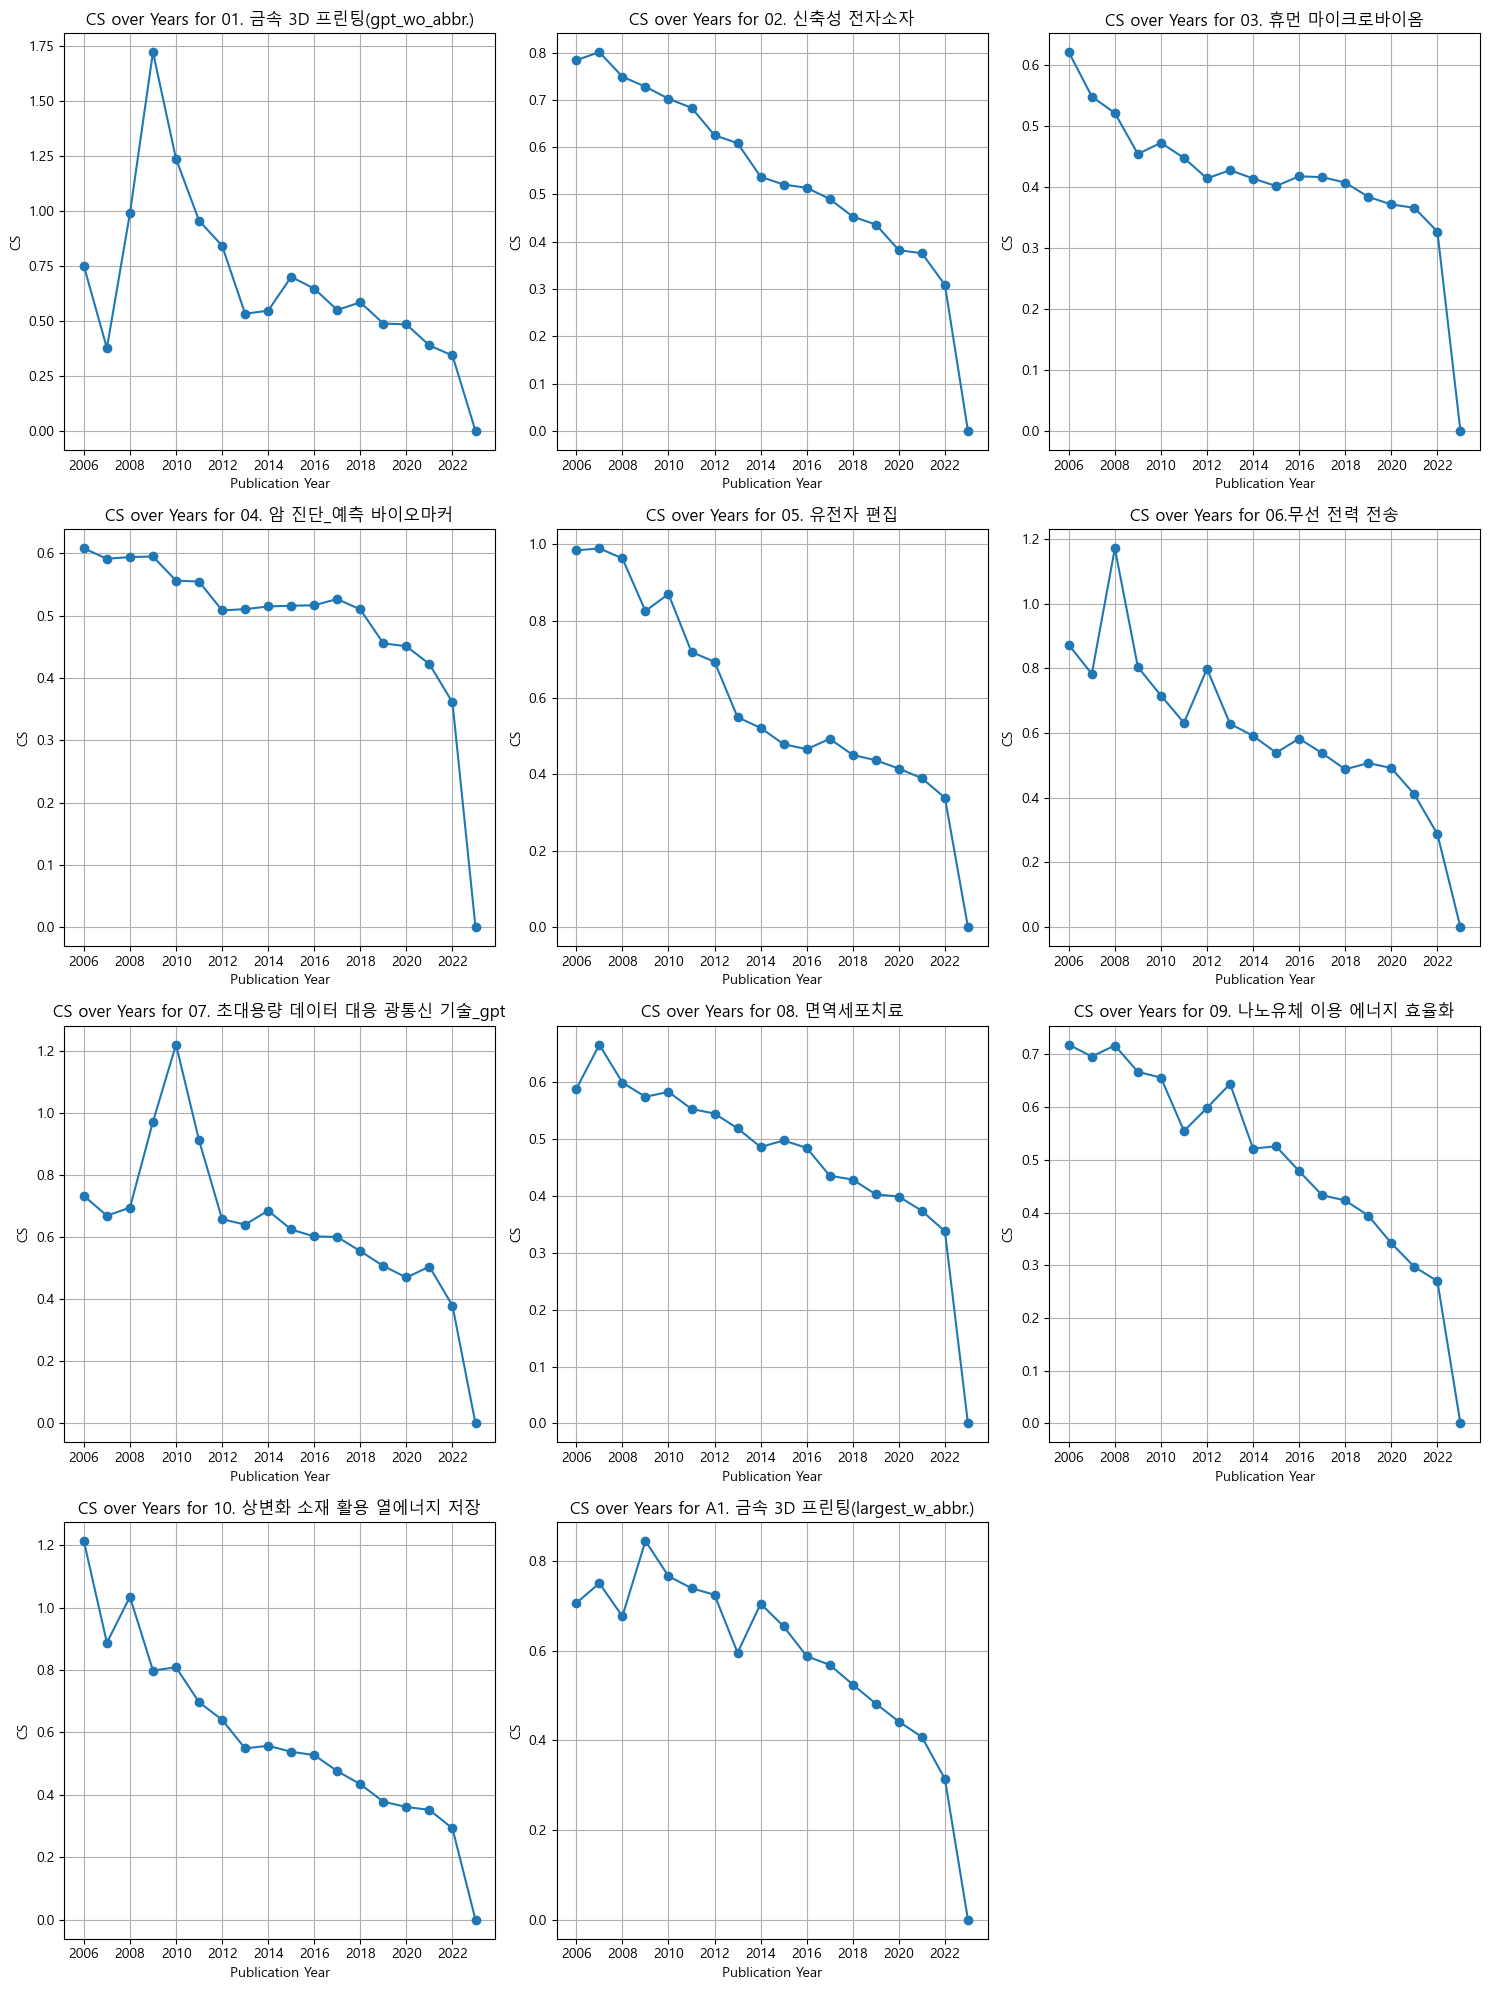

In [131]:
# 시각화
keys = grouped['key'].unique()
num_keys = len(keys)

fig, axes = plt.subplots(nrows=(num_keys + 2) // 3, ncols=3, figsize=(15, 5 * ((num_keys + 2) // 3)))

for i, key in enumerate(keys):
    ax = axes[i // 3, i % 3]
    subset = grouped[grouped['key'] == key]
    ax.plot(subset['pubyear'], subset['CS'], marker='o')
    ax.set_title(f'CS over Years for {key}')
    ax.set_xlabel('Publication Year')
    ax.set_ylabel('CS')
    ax.grid(True)
    
    # x축 눈금을 2년 간격으로 설정
    years = subset['pubyear'].astype(int)
    min_year = years.min()
    max_year = years.max()
    ax.set_xticks(range(min_year, max_year + 1, 2))
    ax.set_xticklabels(range(min_year, max_year + 1, 2))

# 마지막 사용되지 않는 서브플롯 비우기
if num_keys % 3 != 0:
    for j in range(num_keys, ((num_keys + 2) // 3) * 3):
        fig.delaxes(axes[j // 3, j % 3])

# 레이아웃 조정
plt.tight_layout()

# 파일로 저장
plt.savefig('citation_speed_visualization.png', format='png')

# 그래프를 화면에 표시
plt.show()

In [76]:

# 음수가 아닌 최소 citation_lag를 uid별로 찾기
#valid_citation_lag = df_merged[df_merged['citation_lag'] >= 0]
#min_citation_lag_per_uid = valid_citation_lag.groupby('uid')['citation_lag'].min().reset_index()

# 음수가 아닌 최소 citation_lag를 uid별로 찾기
#def get_min_citation_lag(group):
    non_negative_lags = group[group['citation_lag'] >= 0]['citation_lag']
    if len(non_negative_lags) > 0:
        return non_negative_lags.min()
    else:
        return 0

#min_citation_lag_per_uid = df_merged.groupby('uid').apply(get_min_citation_lag).reset_index()
#min_citation_lag_per_uid.columns = ['uid', 'min_citation_lag']

C:\Users\skim\AppData\Local\Temp\ipykernel_3048\1694993988.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_citation_lag_per_uid = df_merged.groupby('uid').apply(get_min_citation_lag).reset_index()


In [75]:
len(df_merged['uid'].unique())

521518

In [71]:
min_citation_lag_per_uid.shape

(521367, 2)

In [73]:
min_citation_lag_per_uid['citation_lag'].max()

np.int64(17)

In [66]:
# 인용의 출판 연도와 논문의 출판 연도 사이의 연도 차이 (citation_lag)를 기준으로 지수 가중치를 적용하여 평균 계산
#def calculate_cs(group):
    # citation_lag가 음수 값이 아닌 경우만 고려하여 첫 인용 (최소 citation_lag) 선택
    valid_group = group[group['citation_lag'] >= 0]
    min_citation_lag = valid_group.groupby('uid')['citation_lag'].min().reset_index()
    
    # 유효 인용: 출판 연도 + 4년 이내에 첫 인용된 문서 필터링
    valid_citations = min_citation_lag[min_citation_lag['citation_lag'] <= 4]
    
    # 지수 가중치 적용
    weights = np.exp(-valid_citations['citation_lag'])
    
    # CS 지표 계산
    cs = (weights * valid_citations['citation_lag']).sum() / weights.sum() if weights.sum() != 0 else 0
    
    return cs

In [81]:
def get_min_citation_lag(df_merged):
    non_negative_lags = df_merged[df_merged['citation_lag'] >= 0]
    min_citation_lag_per_uid = non_negative_lags.groupby('uid')['citation_lag'].min().reset_index()
    min_citation_lag_per_uid.columns = ['uid', 'min_citation_lag']
    
    # citation_lag가 음수가 아닌 값이 없는 경우, citation_lag를 0으로 설정
    all_uids = df_merged['uid'].unique()
    complete_min_lags = pd.DataFrame(all_uids, columns=['uid']).merge(
        min_citation_lag_per_uid, on='uid', how='left').fillna(0)
    return complete_min_lags

def calculate_cs(df_merged):
    min_citation_lag_per_uid = get_min_citation_lag(df_merged)
    
    # 유효 인용: 출판 연도 + 4년 이내에 첫 인용된 문서 필터링
    valid_citations = min_citation_lag_per_uid[min_citation_lag_per_uid['min_citation_lag'] <= 4]
    
    # 지수 가중치 적용
    weights = np.exp(-valid_citations['min_citation_lag'])
    
    # CS 지표 계산
    cs = (weights * valid_citations['min_citation_lag']).sum() / weights.sum() if weights.sum() != 0 else 0
    
    return cs


In [82]:
# 연도별, key별로 그룹화하여 CS 지표 계산
cs_df = df_merged.groupby(['pubyear', 'key']).apply(calculate_cs).reset_index()
cs_df.columns = ['pubyear', 'key', 'CS']

C:\Users\skim\AppData\Local\Temp\ipykernel_3048\3005723900.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cs_df = df_merged.groupby(['pubyear', 'key']).apply(calculate_cs).reset_index()


In [83]:
cs_df

,pubyear,key,CS
0,2006,01. 금속 3D 프린팅(gpt_wo_abbr.),0.252007
1,2006,02. 신축성 전자소자,0.452162
2,2006,03. 휴먼 마이크로바이옴,0.397178
3,2006,04. 암 진단_예측 바이오마커,0.398274
4,2006,05. 유전자 편집,0.547077
...,...,...,...
193,2023,07. 초대용량 데이터 대응 광통신 기술_gpt,0.000000
194,2023,08. 면역세포치료,0.000000
195,2023,09. 나노유체 이용 에너지 효율화,0.000000
196,2023,10. 상변화 소재 활용 열에너지 저장,0.000000


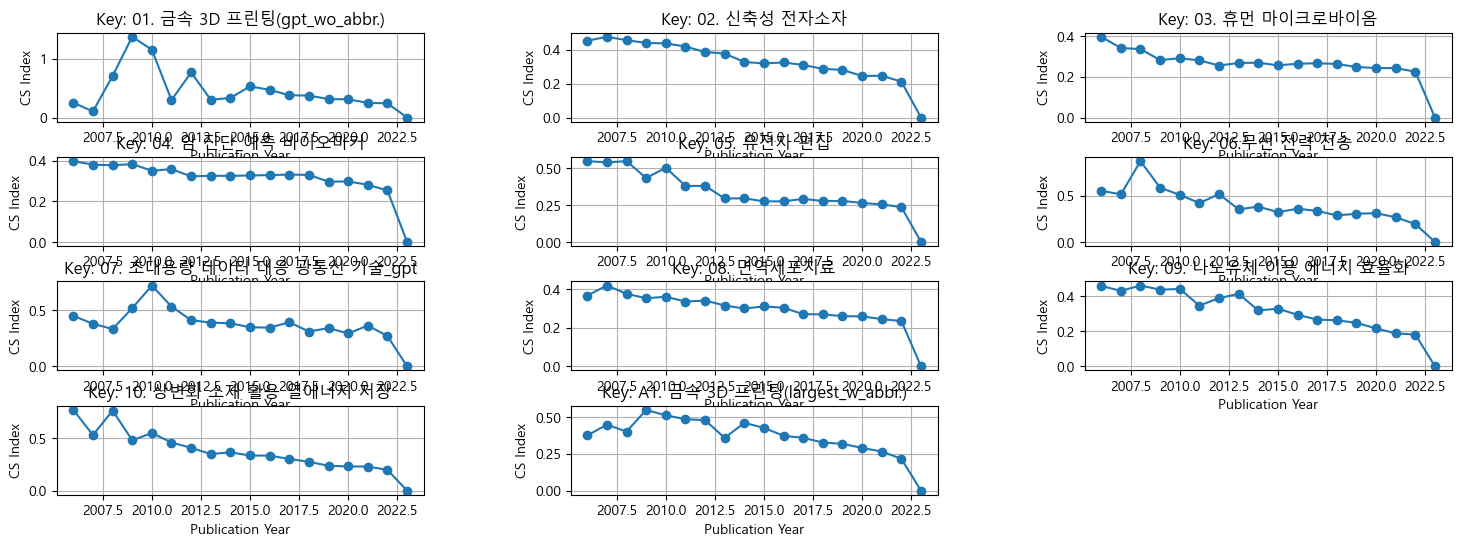

In [84]:
# 키별 연도별 CS 지표를 시각화
keys = cs_df['key'].unique()
num_keys = len(keys)

fig, axs = plt.subplots(nrows=(num_keys // 3) + (1 if num_keys % 3 != 0 else 0), ncols=3, figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axs = axs.ravel()

for i, key in enumerate(keys):
    key_data = cs_df[cs_df['key'] == key]
    axs[i].plot(key_data['pubyear'], key_data['CS'], marker='o')
    axs[i].set_title(f'Key: {key}')
    axs[i].set_xlabel('Publication Year')
    axs[i].set_ylabel('CS Index')
    axs[i].grid(True)

# Remove empty subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.show()

In [85]:
def calculate_average_first_citation(df_merged):
    min_citation_lag_per_uid = get_min_citation_lag(df_merged)
    
    # 유효 인용: 출판 연도 + 4년 이내에 첫 인용된 문서 필터링
    valid_citations = min_citation_lag_per_uid[min_citation_lag_per_uid['min_citation_lag'] <= 4]
    
    # 첫 인용까지 min_citation_lag 값의 산술평균 계산
    if not valid_citations.empty:
        average_first_citation = valid_citations['min_citation_lag'].mean()
    else:
        average_first_citation = 0
    
    return average_first_citation

In [86]:
# 연도별, key별로 그룹화하여 CS 지표 계산
afc_df = df_merged.groupby(['pubyear', 'key']).apply(calculate_average_first_citation).reset_index()
afc_df.columns = ['pubyear', 'key', 'afc']

C:\Users\skim\AppData\Local\Temp\ipykernel_3048\4029372265.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  afc_df = df_merged.groupby(['pubyear', 'key']).apply(calculate_average_first_citation).reset_index()


In [87]:
afc_df

,pubyear,key,afc
0,2006,01. 금속 3D 프린팅(gpt_wo_abbr.),0.800000
1,2006,02. 신축성 전자소자,1.079148
2,2006,03. 휴먼 마이크로바이옴,0.888158
3,2006,04. 암 진단_예측 바이오마커,0.846348
4,2006,05. 유전자 편집,1.343949
...,...,...,...
193,2023,07. 초대용량 데이터 대응 광통신 기술_gpt,0.000000
194,2023,08. 면역세포치료,0.000000
195,2023,09. 나노유체 이용 에너지 효율화,0.000000
196,2023,10. 상변화 소재 활용 열에너지 저장,0.000000


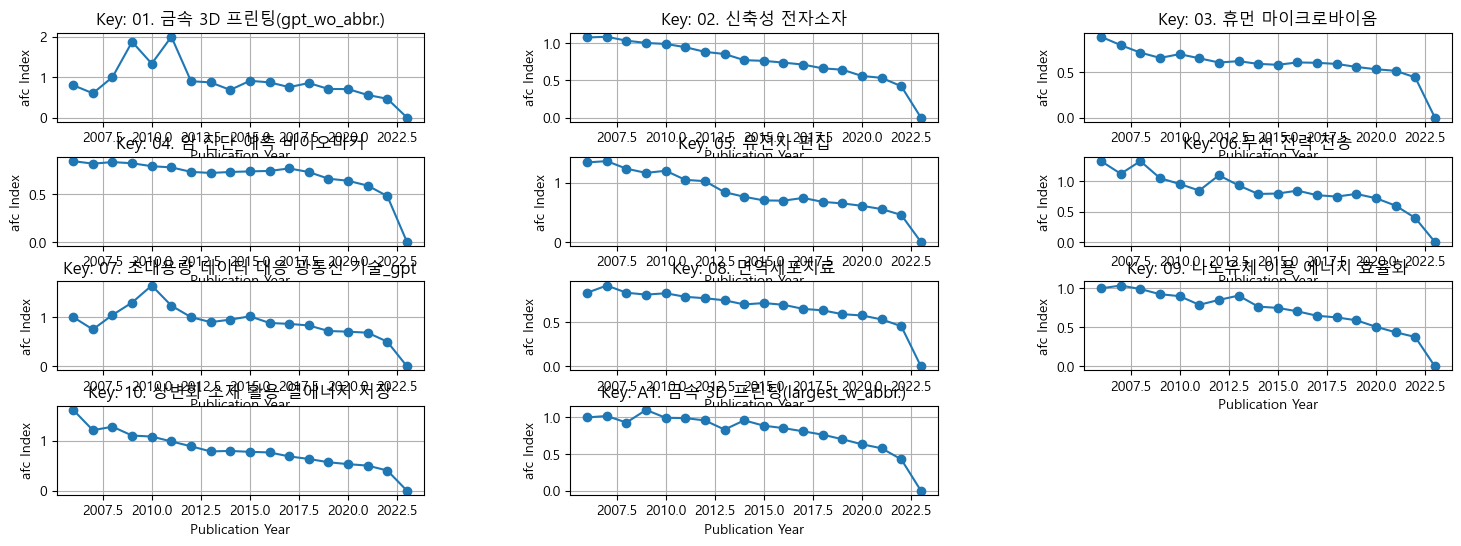

In [88]:
# 키별 연도별 afc 지표를 시각화
keys = afc_df['key'].unique()
num_keys = len(keys)

fig, axs = plt.subplots(nrows=(num_keys // 3) + (1 if num_keys % 3 != 0 else 0), ncols=3, figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axs = axs.ravel()

for i, key in enumerate(keys):
    key_data = afc_df[afc_df['key'] == key]
    axs[i].plot(key_data['pubyear'], key_data['afc'], marker='o')
    axs[i].set_title(f'Key: {key}')
    axs[i].set_xlabel('Publication Year')
    axs[i].set_ylabel('afc Index')
    axs[i].grid(True)

# Remove empty subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.show()

In [10]:
## df_pubinfo_year 변경
df_later_pub = df_pubinfo_year
df_later_pub.columns = ['uid','pubyear']

In [28]:
merged_df.columns = ['citing_uid', 'ref_count', 'cited_uid', 'ref_occurence_order', 'ref_year',
       'ref_uid', 'pubyear_cited', 'key', 'uid', 'pubyear_citing',
       'time_to_first_cite']

In [29]:
merged_df

,citing_uid,ref_count,cited_uid,ref_occurence_order,ref_year,ref_uid,pubyear_cited,key,uid,pubyear_citing,time_to_first_cite
0,WOS:000235283500017,30,WOS:000235283500024,15,2006,WOS:000235283500024,2006,08. 면역세포치료,WOS:000235283500017,2006,0
1,WOS:000243137600019,22,WOS:000235041000006,22,2006,WOS:000235041000006,2006,04. 암 진단_예측 바이오마커,WOS:000243137600019,2006,0
2,WOS:000240537700013,32,WOS:000237828500021,29,2006,WOS:000237828500021,2006,08. 면역세포치료,WOS:000240537700013,2006,0
3,WOS:000234575700001,17,WOS:000234575700003,1,2006,WOS:000234575700003,2006,08. 면역세포치료,WOS:000234575700001,2006,0
4,WOS:000234575700001,17,WOS:000234575700006,6,2006,WOS:000234575700006,2006,08. 면역세포치료,WOS:000234575700001,2006,0
...,...,...,...,...,...,...,...,...,...,...,...
19220829,WOS:001060921300001,13,WOS:000345478500009,7,2014,WOS:000345478500009,2014,04. 암 진단_예측 바이오마커,WOS:001060921300001,2023,9
19220830,WOS:001060921300001,13,WOS:000345478500009,7,2014,WOS:000345478500009,2014,08. 면역세포치료,WOS:001060921300001,2023,9
19220831,WOS:001060921300001,13,WOS:000345199200008,6,2014,WOS:000345199200008,2014,04. 암 진단_예측 바이오마커,WOS:001060921300001,2023,9
19220832,WOS:001131480600001,131,WOS:000548042300001,57,2020,WOS:000548042300001,2020,06.무선 전력 전송,WOS:001131480600001,2023,3


In [13]:
# Merge df_pub and df first
merged_df = pd.merge(df, df_pub, left_on='ref_uid', right_on='uid', suffixes=('_citing', '_cited'))

In [19]:
# Rename the columns to avoid confusion in the next merge
merged_df = merged_df.rename(columns={'uid_citing': 'citing_uid', 'uid_cited': 'ref_uid', 'pubyear': 'pubyear_cited'})

In [21]:
# Merge the resulting dataframe with df_later_pub to get the publication year of the citing papers
merged_df = pd.merge(merged_df, df_later_pub, left_on='citing_uid', right_on='uid', suffixes=('', '_citing'))

In [23]:
# Rename columns to avoid confusion
merged_df = merged_df.rename(columns={'pubyear': 'pubyear_citing'})

In [24]:
# Calculate the time difference between the publication year of the cited paper and the citing paper
merged_df['time_to_first_cite'] = merged_df['pubyear_citing'] - merged_df['pubyear_cited']

In [30]:
# Select the minimum time_to_first_cite for each ref_uid
first_cite_df = merged_df.groupby('ref_uid')['time_to_first_cite'].min().reset_index()

In [31]:
merged_df

,citing_uid,ref_count,cited_uid,ref_occurence_order,ref_year,ref_uid,pubyear_cited,key,uid,pubyear_citing,time_to_first_cite
0,WOS:000235283500017,30,WOS:000235283500024,15,2006,WOS:000235283500024,2006,08. 면역세포치료,WOS:000235283500017,2006,0
1,WOS:000243137600019,22,WOS:000235041000006,22,2006,WOS:000235041000006,2006,04. 암 진단_예측 바이오마커,WOS:000243137600019,2006,0
2,WOS:000240537700013,32,WOS:000237828500021,29,2006,WOS:000237828500021,2006,08. 면역세포치료,WOS:000240537700013,2006,0
3,WOS:000234575700001,17,WOS:000234575700003,1,2006,WOS:000234575700003,2006,08. 면역세포치료,WOS:000234575700001,2006,0
4,WOS:000234575700001,17,WOS:000234575700006,6,2006,WOS:000234575700006,2006,08. 면역세포치료,WOS:000234575700001,2006,0
...,...,...,...,...,...,...,...,...,...,...,...
19220829,WOS:001060921300001,13,WOS:000345478500009,7,2014,WOS:000345478500009,2014,04. 암 진단_예측 바이오마커,WOS:001060921300001,2023,9
19220830,WOS:001060921300001,13,WOS:000345478500009,7,2014,WOS:000345478500009,2014,08. 면역세포치료,WOS:001060921300001,2023,9
19220831,WOS:001060921300001,13,WOS:000345199200008,6,2014,WOS:000345199200008,2014,04. 암 진단_예측 바이오마커,WOS:001060921300001,2023,9
19220832,WOS:001131480600001,131,WOS:000548042300001,57,2020,WOS:000548042300001,2020,06.무선 전력 전송,WOS:001131480600001,2023,3


In [36]:
first_cite_df[first_cite_df.time_to_first_cite<-10]

,ref_uid,time_to_first_cite
241741,WOS:000462519200001,-13
258064,WOS:000477455600001,-13
258926,WOS:000478263900001,-11
275348,WOS:000498987800001,-14


In [38]:
merged_df[merged_df['ref_uid']=='WOS:000498987800001']

,citing_uid,ref_count,cited_uid,ref_occurence_order,ref_year,ref_uid,pubyear_cited,key,uid,pubyear_citing,time_to_first_cite
1259,WOS:000235726300005,76,WOS:000498987800001,49,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000235726300005,2006,-14
24522,WOS:000247003100010,42,WOS:000498987800001,28,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000247003100010,2007,-13
10995508,WOS:000670108600005,83,WOS:000498987800001,42,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000670108600005,2021,1
11287580,WOS:000653496200001,44,WOS:000498987800001,43,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000653496200001,2021,1
14788412,WOS:000869063000002,154,WOS:000498987800001,77,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000869063000002,2022,2
15246829,WOS:000801117600001,22,WOS:000498987800001,6,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000801117600001,2022,2
15584839,WOS:000716368200001,22,WOS:000498987800001,11,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000716368200001,2023,3
16746502,WOS:000943088500001,100,WOS:000498987800001,62,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000943088500001,2023,3
16873408,WOS:000940666000001,90,WOS:000498987800001,90,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:000940666000001,2023,3
19213608,WOS:001030358400001,22,WOS:000498987800001,6,2020,WOS:000498987800001,2020,04. 암 진단_예측 바이오마커,WOS:001030358400001,2023,3


In [39]:
# Function to calculate the exponential weighted average for CS considering the 5-year citation window
def calculate_cs(df):
    df['time_to_first_cite'] = df['time_to_first_cite'].apply(lambda x: x if x <= 4 else float('inf'))
    # Set weights: 0 for infinite response times, exp(-Y_r) for others
    weights = np.exp(-df['time_to_first_cite'])
    weights[df['time_to_first_cite'] == float('inf')] = 0
    # Calculate the weighted average
    cs_value = np.average(df['time_to_first_cite'], weights=weights)
    return cs_value

In [40]:
# Merge first_cite_df with df_pub to get the 'key' and 'pubyear' columns
first_cite_with_key = pd.merge(first_cite_df, df_pub, left_on='ref_uid', right_on='uid')

In [42]:
first_cite_with_key

,ref_uid,time_to_first_cite,uid,pubyear,key
0,WOS:000202946800014,0,WOS:000202946800014,2007,04. 암 진단_예측 바이오마커
1,WOS:000202981600002,1,WOS:000202981600002,2006,04. 암 진단_예측 바이오마커
2,WOS:000202981600011,1,WOS:000202981600011,2006,04. 암 진단_예측 바이오마커
3,WOS:000202981700010,0,WOS:000202981700010,2006,04. 암 진단_예측 바이오마커
4,WOS:000202981700012,1,WOS:000202981700012,2006,04. 암 진단_예측 바이오마커
...,...,...,...,...,...
536742,WOS:001184860900001,0,WOS:001184860900001,2023,03. 휴먼 마이크로바이옴
536743,WOS:001187299700013,0,WOS:001187299700013,2023,09. 나노유체 이용 에너지 효율화
536744,WOS:001187367500001,1,WOS:001187367500001,2022,03. 휴먼 마이크로바이옴
536745,WOS:001187419100001,1,WOS:001187419100001,2022,05. 유전자 편집


In [47]:
first_cite_with_key.groupby(['pubyear', 'key']).apply(calculate_cs)

F:\Projtest\pjtest\Lib\site-packages\numpy\lib\_function_base_impl.py:573: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
F:\Projtest\pjtest\Lib\site-packages\numpy\lib\_function_base_impl.py:573: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
F:\Projtest\pjtest\Lib\site-packages\numpy\lib\_function_base_impl.py:573: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
F:\Projtest\pjtest\Lib\site-packages\numpy\lib\_function_base_impl.py:573: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
F:\Projtest\pjtest\Lib\site-packages\numpy\lib\_function_base_impl.py:573: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
F:\Projtest\pjtest\Lib\site-packages\numpy\lib\_function_base_impl.py:573: RuntimeWarning: invalid value encountered in multiply
  avg = avg

pubyear  key                           
2006     01. 금속 3D 프린팅(gpt_wo_abbr.)            NaN
         02. 신축성 전자소자                           NaN
         03. 휴먼 마이크로바이옴                         NaN
         04. 암 진단_예측 바이오마커                      NaN
         05. 유전자 편집                             NaN
                                             ...   
2023     07. 초대용량 데이터 대응 광통신 기술_gpt        0.000000
         08. 면역세포치료                       -0.104798
         09. 나노유체 이용 에너지 효율화              -0.199352
         10. 상변화 소재 활용 열에너지 저장            -0.103186
         A1. 금속 3D 프린팅(largest_w_abbr.)   -0.137912
Length: 198, dtype: float64

In [41]:
# Group by 'pubyear' and 'key', and calculate CS for each group
cs_by_year_key = first_cite_with_key.groupby(['pubyear', 'key'])['time_to_first_cite'].apply(calculate_cs).reset_index()
cs_by_year_key.columns = ['pubyear', 'key', 'CS']

KeyError: 'time_to_first_cite'

In [ ]:
# Plotting the CS values for each technology and year
import matplotlib.pyplot as plt

# Merge CS values with df_pub to get the technology keys
cs_merged = pd.merge(cs_values, df_pub, on='uid')

unique_keys = cs_merged['uid'].unique()
num_keys = len(unique_keys)

# Determine number of rows needed for subplot grid
num_cols = 3
num_rows = (num_keys + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)
axes = axes.flatten()

for idx, key in enumerate(unique_keys):
    ax = axes[idx]
    tech_data = cs_merged[cs_merged['uid'] == key]
    ax.plot(tech_data['pubyear'], tech_data['CS'], marker='o')
    ax.set_title(f'CS for {key}')
    ax.set_xlabel('Year')
    ax.set_ylabel('CS')

# Hide any unused subplots
for idx in range(len(unique_keys), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [11]:
# 데이터프레임이름 업데이트
df_refer = df



# Citation Speed (CS, 인용속도) 계산하기

## 2018 10대기술 검색결과 불러오기

In [57]:
# 기본 경로 지정
base_path = 'F:/cluster_test_2024/search_results_2024_06-04_combined'

# 결과를 저장할 딕셔너리 초기화
df_combined_dict = {}

# 모든 파일을 검색하여 딕셔너리에 저장
for filename in os.listdir(base_path):
    if filename.endswith('_aukey_or_abs_search_results_textinfo.csv'):
        # 파일의 전체 경로
        file_path = os.path.join(base_path, filename)
        
        # 파일명에서 '_aukey_or_abs_search_results_textinfo.csv'를 제외한 앞부분을 키로 사용
        key = filename.replace('_aukey_or_abs_search_results_textinfo.csv', '')
        
        # CSV 파일을 데이터프레임으로 읽어와 딕셔너리에 저장
        df_combined_dict[key] = pd.read_csv(file_path)

# 결과 확인
for key, df in df_combined_dict.items():
    print(f"Key: {key}, DataFrame Shape: {df.shape}")


Key: 1-1. 금속 3D 프린팅(A-set)3, DataFrame Shape: (795, 6)
Key: 1-1. 금속 3D 프린팅(A-set)gpt, DataFrame Shape: (8014, 6)
Key: 1-1. 금속 3D 프린팅(A-set)gpt_smaller, DataFrame Shape: (710, 6)
Key: 1-2. 금속 3D 프린팅(B-set)gpt, DataFrame Shape: (959, 6)
Key: 1-2. 금속 3D 프린팅(B-set), DataFrame Shape: (5276, 6)
Key: 10. 상변화 소재 활용 열에너지 저장, DataFrame Shape: (22460, 6)
Key: 2. 신축성 전자소자, DataFrame Shape: (135734, 6)
Key: 3. 휴먼 마이크로바이옴, DataFrame Shape: (75630, 6)
Key: 4. 암 진단_예측 바이오마커, DataFrame Shape: (157015, 6)
Key: 5. 유전자 편집, DataFrame Shape: (59997, 6)
Key: 6.무선 전력 전송, DataFrame Shape: (6729, 6)
Key: 7. 초대용량 데이터 대응 광통신 기술, DataFrame Shape: (22242, 6)
Key: 7. 초대용량 데이터 대응 광통신 기술_gpt, DataFrame Shape: (1304, 6)
Key: 8. 면역세포치료, DataFrame Shape: (96932, 6)
Key: 9. 나노유체 이용 에너지 효율화, DataFrame Shape: (32067, 6)


In [58]:
len(df_combined_dict)

15

In [51]:
# 함수 정의: 각 'pubyear' 그룹에 대해 필요한 계산을 수행
def compute_statistics(df):
    grouped_by_uid = df.groupby('uid').agg({
        'firstCitingYear': ['min'],
        'citing_year': ['mean']
    })
    grouped_by_uid.columns = ['min_citing_year', 'mean_citing_year']
    
    min_citing_year_avg = grouped_by_uid['min_citing_year'].mean()
    mean_citing_year_avg = grouped_by_uid['mean_citing_year'].mean()

    # 필터링: 출판 연도 + 4년 이내에 첫 인용된 문서
    df_filtered = df[df['firstCitingYear'] <= df['pubyear'] + 4]

    # 지수 함수 값 계산
    df_filtered['exp_term'] = np.exp(-(df_filtered['firstCitingYear'] - df_filtered['pubyear']))

    # 분자 계산
    numerator = df_filtered['exp_term'].sum()

    # 분모 계산
    denominator = df_filtered.shape[0]

    # 수식 계산
    Citation_speed = numerator / denominator if denominator != 0 else 0
    
    return pd.Series({
        'min_citing_year_avg': min_citing_year_avg,
        'mean_citing_year_avg': mean_citing_year_avg,
        'Citation_speed': Citation_speed
    })

# 피인용 확인
## 분석대상 기술별

In [87]:
# CS 지표를 저장할 딕셔너리 초기화
cs_dict_yearly = {}
result_dict_yearly = {}
print(f'Start time: {elapsed_time:.2f} seconds')

for key in df_combined_dict.keys():
    start_time = time.time()  # 시작 시간 기록
    print(f'now: {key}')
    df_cited = df_combined_dict[key][['uid','pubyear']]
    # df_cited uid 추출
    uids = df_cited['uid'].unique()
    # df_refer에서 같은 uid를 가진 행 추출
    df_refer_filtered = df_refer[df_refer['ref_uid'].isin(uids)]
    df_refer_filtered.columns = ['citing_uid', 'ref_count', 'uid', 'ref_occurence_order', 'pubyear']
    df_citation_pair = df_refer_filtered[['uid', 'pubyear', 'citing_uid']]
    df_citation_pair_with_year = df_citation_pair.merge(df_pubinfo_year, left_on='citing_uid', right_on='citing_uid', how='inner')
    
    # 'pubyear'별로 그룹화하여 계산
    grouped = df_citation_pair_with_year.groupby('pubyear')
    
    # firstCitingYear 계산
    df_first_citing_year = df_citation_pair_with_year.groupby('uid')['citing_year'].min().reset_index()
    df_first_citing_year.columns = ['uid', 'firstCitingYear']

    # 원본 데이터프레임과 병합
    df_combined = pd.merge(df_citation_pair_with_year, df_first_citing_year, on='uid')
    
    # 'pubyear'별로 그룹화하여 계산
    grouped = df_combined.groupby('pubyear')
    result = grouped.apply(compute_statistics).reset_index()
    
    # 결과를 딕셔너리에 저장
    result_dict_yearly[key] = result
    cs_dict_yearly[key] = result[['pubyear','Citation_speed']]

    end_time = time.time()  # 종료 시간 기록
    elapsed_time = end_time - start_time  # 소요 시간 계산
    print(f'Time taken for {key}: {elapsed_time:.2f} seconds')

Start time: 1803.74 seconds
now: 1-1. 금속 3D 프린팅(A-set)3
Time taken for 1-1. 금속 3D 프린팅(A-set)3: 117.87 seconds
now: 1-1. 금속 3D 프린팅(A-set)gpt
Time taken for 1-1. 금속 3D 프린팅(A-set)gpt: 175.53 seconds
now: 1-1. 금속 3D 프린팅(A-set)gpt_smaller
Time taken for 1-1. 금속 3D 프린팅(A-set)gpt_smaller: 168.85 seconds
now: 1-2. 금속 3D 프린팅(B-set)gpt
Time taken for 1-2. 금속 3D 프린팅(B-set)gpt: 130.19 seconds
now: 1-2. 금속 3D 프린팅(B-set)
Time taken for 1-2. 금속 3D 프린팅(B-set): 205.15 seconds
now: 10. 상변화 소재 활용 열에너지 저장
Time taken for 10. 상변화 소재 활용 열에너지 저장: 263.56 seconds
now: 2. 신축성 전자소자
Time taken for 2. 신축성 전자소자: 257.20 seconds
now: 3. 휴먼 마이크로바이옴
Time taken for 3. 휴먼 마이크로바이옴: 252.03 seconds
now: 4. 암 진단_예측 바이오마커
Time taken for 4. 암 진단_예측 바이오마커: 311.63 seconds
now: 5. 유전자 편집
Time taken for 5. 유전자 편집: 190.02 seconds
now: 6.무선 전력 전송
Time taken for 6.무선 전력 전송: 149.60 seconds
now: 7. 초대용량 데이터 대응 광통신 기술
Time taken for 7. 초대용량 데이터 대응 광통신 기술: 263.07 seconds
now: 7. 초대용량 데이터 대응 광통신 기술_gpt
Time taken for 7. 초대용량 데이터 대응 광통신 기술_

C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 54021 (\N{HANGUL SYLLABLE TING}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
C

C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  plt.tight_layout()
C:\Users\skim\AppData\Local\Temp\ipykernel_15260\1616391530.py:18: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from current font.
  plt.tight_layout()
C:\U

F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\Projtest\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47308 (\N

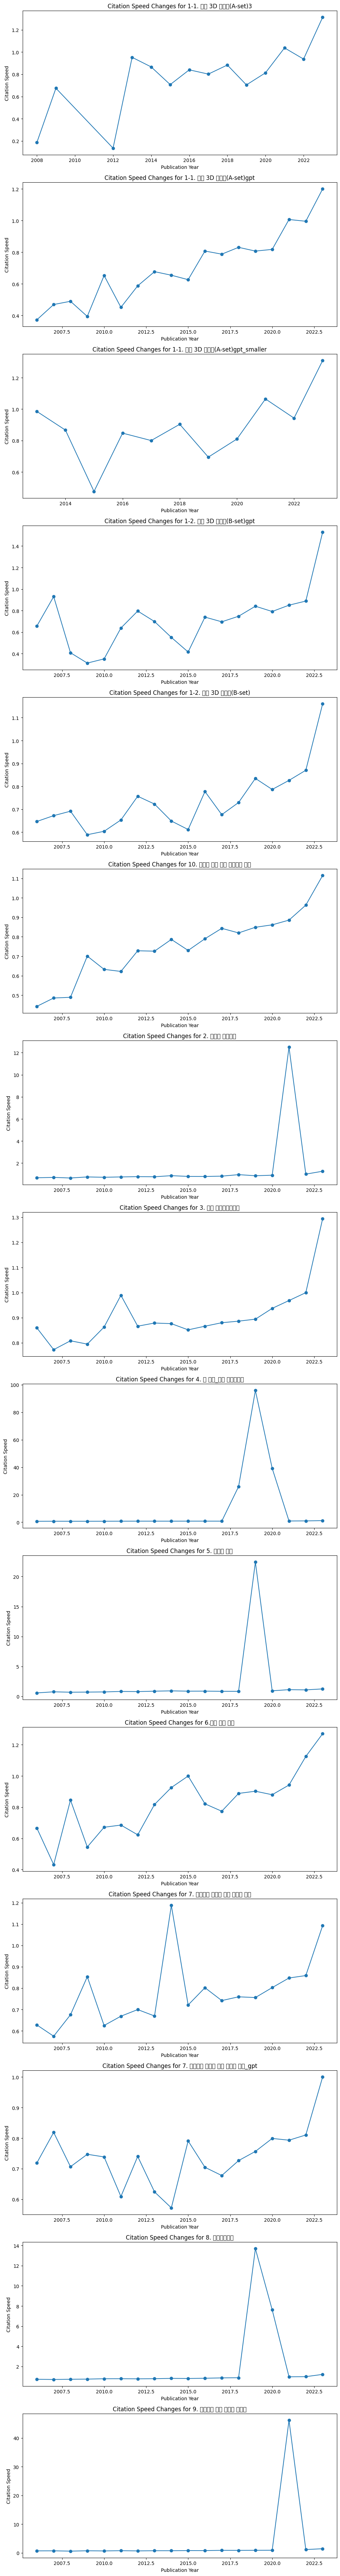

In [88]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

# 연도별 Citation_speed 값을 저장할 리스트
citation_speeds = [result_dict_yearly[key][['pubyear', 'Citation_speed']] for key in result_dict_yearly.keys()]

# 서브플롯 생성
N = len(citation_speeds)
fig, axs = plt.subplots(N, 1, figsize=(10, N * 5))

for i, citation_speed_df in enumerate(citation_speeds):
    axs[i].plot(citation_speed_df['pubyear'], citation_speed_df['Citation_speed'], marker='o')
    axs[i].set_title(f'Citation Speed Changes for {list(result_dict_yearly.keys())[i]}')
    axs[i].set_xlabel('Publication Year')
    axs[i].set_ylabel('Citation Speed')

plt.tight_layout()
plt.show()

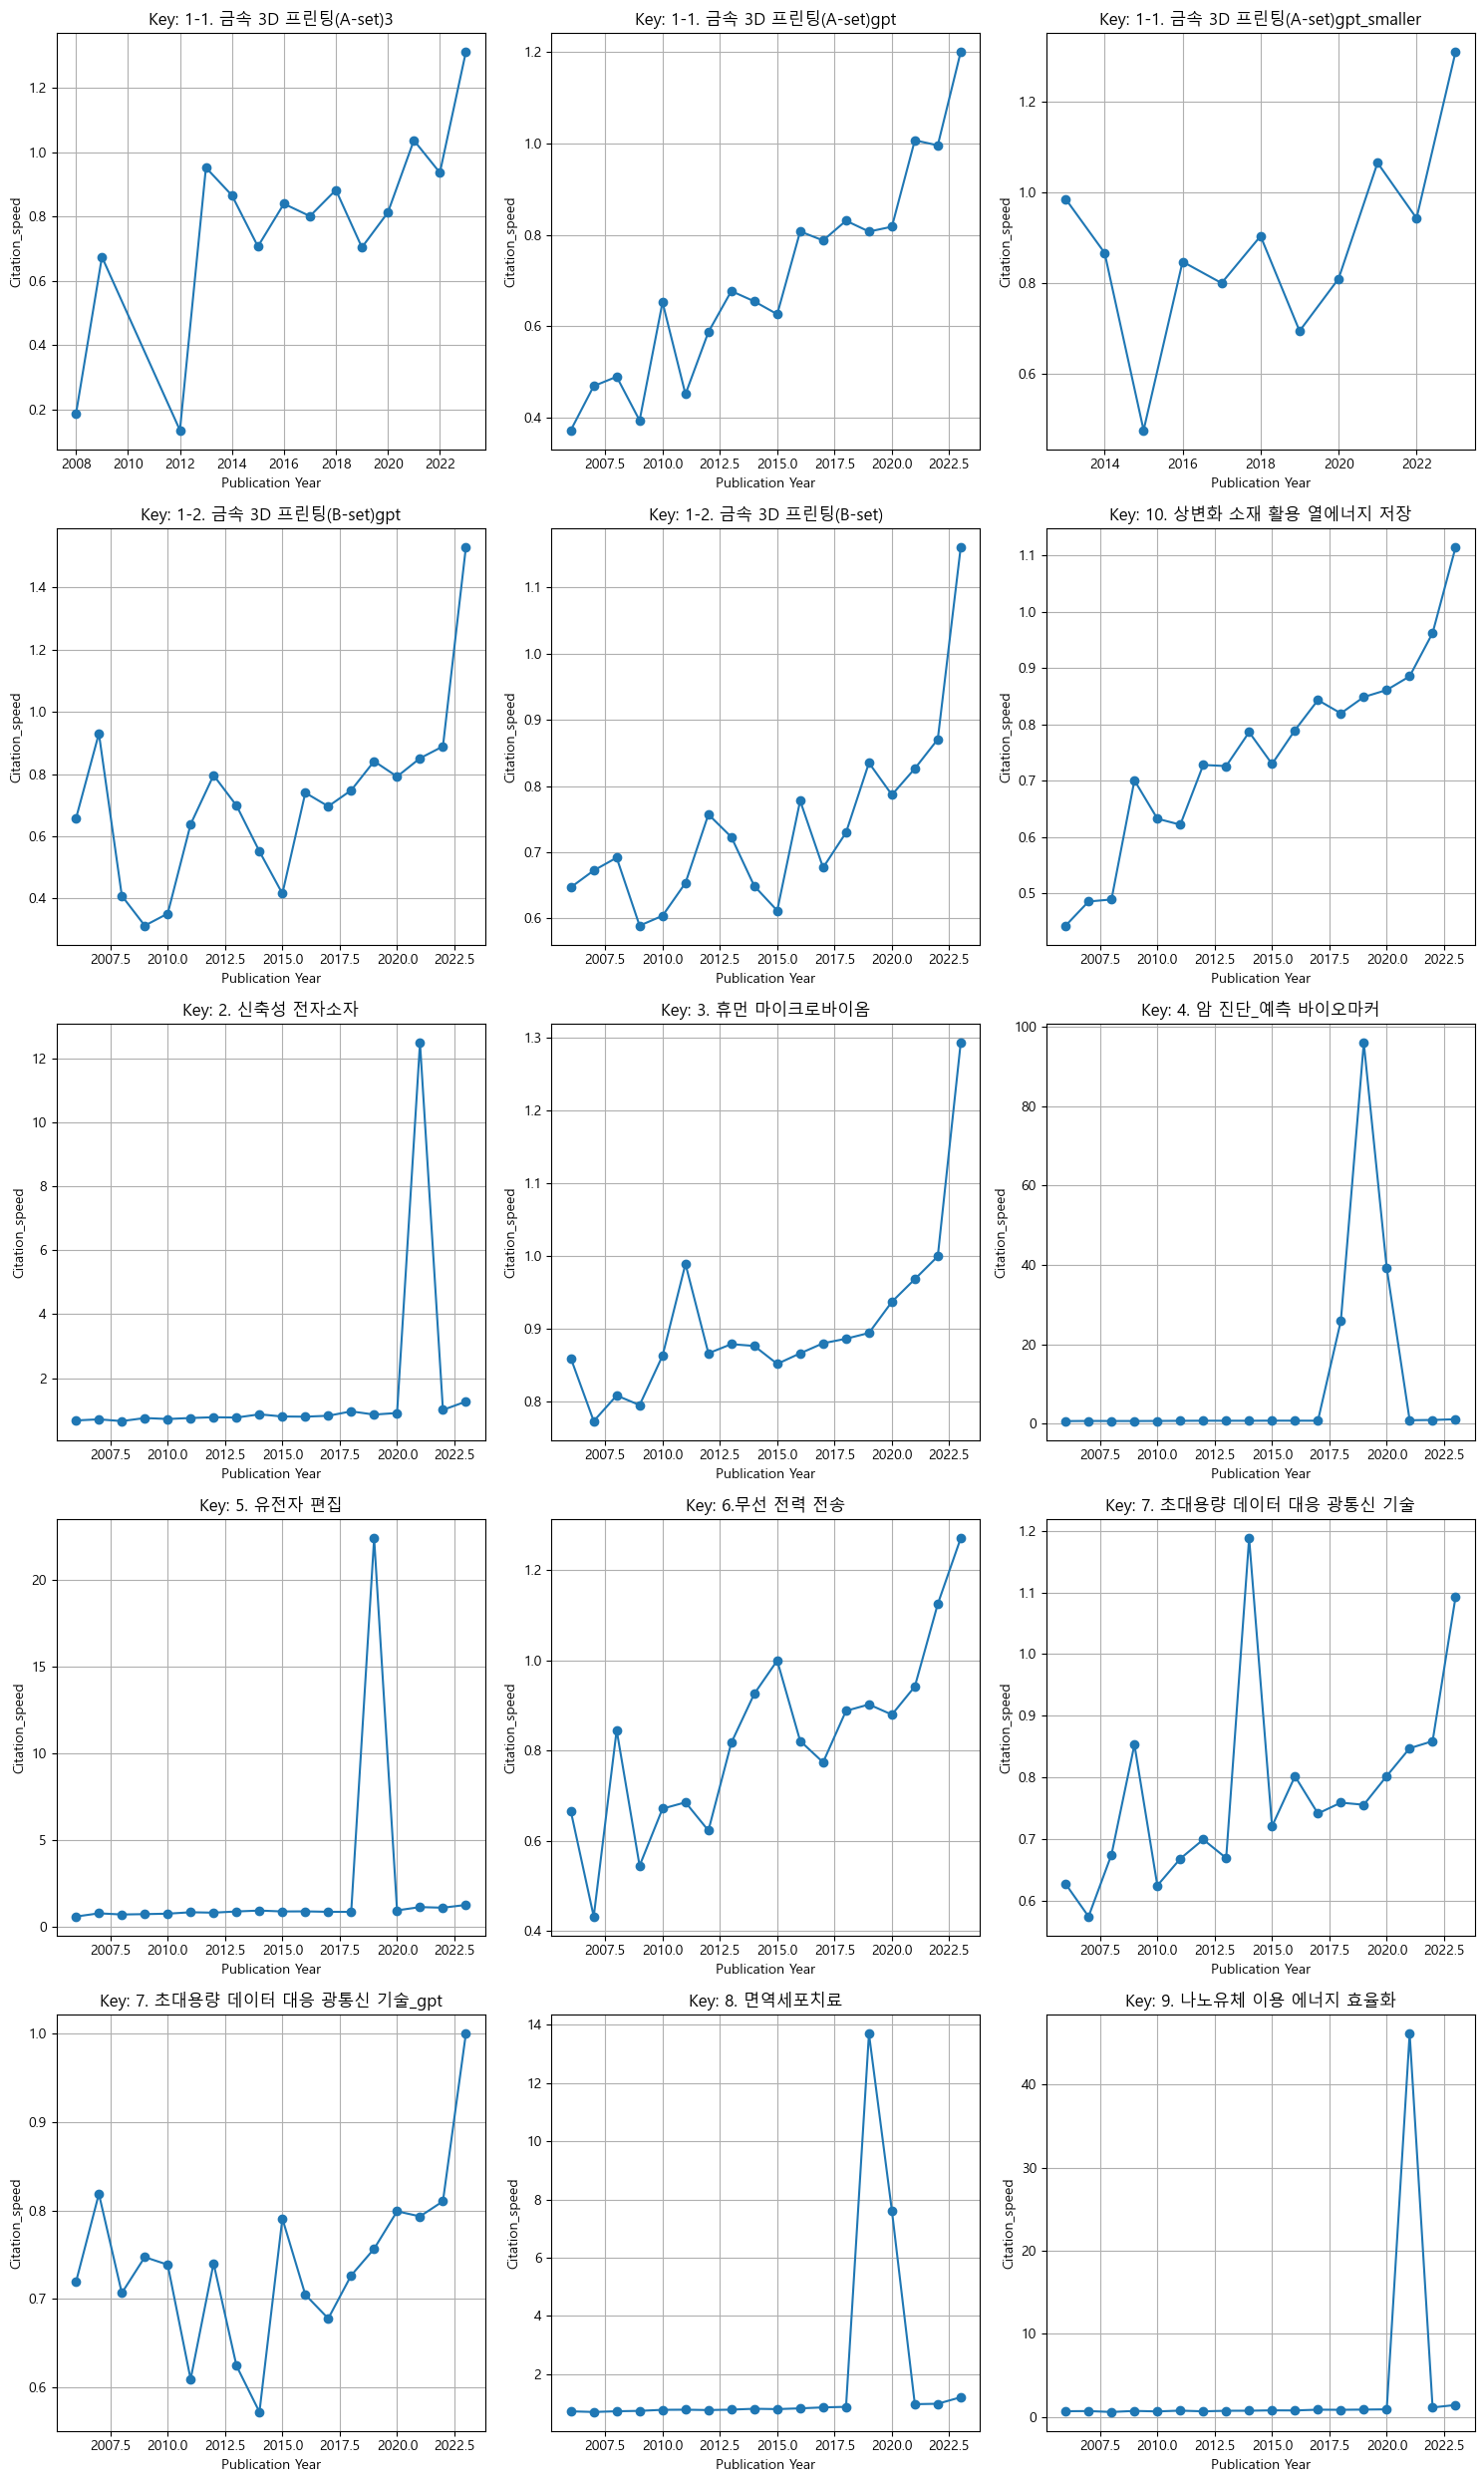

In [91]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 맑은 고딕 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 서브플롯 생성
n_keys = len(cs_dict_yearly)
ncols = 3
nrows = (n_keys + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

# 각 key에 대해 그래프 생성
for i, (key, cs_df) in enumerate(cs_dict_yearly.items()):
    ax = axes[i]
    ax.plot(cs_df['pubyear'], cs_df['Citation_speed'], marker='o', linestyle='-')
    ax.set_title(f'Key: {key}')
    ax.set_xlabel('Publication Year')
    ax.set_ylabel('Citation_speed')
    ax.grid(True)

# 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [62]:
# df_cited uid 추출
uids = df_cited['uid'].unique()

In [75]:
# df_refer에서 같은 uid를 가진 행 추출
df_refer_filtered = df_refer[df_refer['ref_uid'].isin(uids)]

In [78]:
df_refer_filtered.columns = ['citing_uid', 'ref_count', 'uid', 'ref_occurence_order', 'pubyear']

In [79]:
df_citation_pair = df_refer_filtered[['uid', 'pubyear', 'citing_uid']]

In [32]:
#df_citation_pair = df_merged[['uid', 'pubyear', 'citing_uid']]

In [33]:
df_citation_pair_with_year = df_citation_pair.merge(df_pubinfo_year, left_on='citing_uid', right_on='citing_uid', how='inner')

In [34]:
df_citation_pair_with_year

,uid,pubyear,citing_uid,citing_year
0,WOS:000252621500008,2008,WOS:000272563900012,2009
1,WOS:000252621500008,2008,WOS:000275929800135,2009
2,WOS:000252621500008,2008,WOS:000283121300007,2010
3,WOS:000252621500008,2008,WOS:000276004500113,2010
4,WOS:000252621500008,2008,WOS:000288304400013,2011
...,...,...,...,...
160198,WOS:000937195600001,2023,WOS:001017873400001,2023
160199,WOS:000937195600001,2023,WOS:001133762500148,2023
160200,WOS:001087772400011,2023,WOS:001092074700001,2023
160201,WOS:001087772400011,2023,WOS:001078506200001,2023


In [36]:
# 'pubyear'별로 그룹화하여 계산
grouped = df_citation_pair_with_year.groupby('pubyear')

In [43]:
# firstCitingYear 계산
df_first_citing_year = df_citation_pair_with_year.groupby('uid')['citing_year'].min().reset_index()
df_first_citing_year.columns = ['uid', 'firstCitingYear']

# 원본 데이터프레임과 병합
df_combined = pd.merge(df_citation_pair_with_year, df_first_citing_year, on='uid')

In [83]:
df_combined

,uid,pubyear
0,WOS:000252621500008,2008
1,WOS:000258025700008,2008
2,WOS:000272266900007,2009
3,WOS:000268339100031,2009
4,WOS:000267697500048,2009
...,...,...
6724,WOS:000947678100001,2023
6725,WOS:000984243000001,2023
6726,WOS:001124167400013,2023
6727,WOS:001128031700093,2023


In [52]:
# 'pubyear'별로 그룹화하여 계산
grouped = df_combined.groupby('pubyear')
result = grouped.apply(compute_statistics).reset_index()

In [53]:
result

,pubyear,min_citing_year_avg,mean_citing_year_avg,Citation_speed
0,2006,2007.333333,2013.880935,0.666090
1,2007,2008.125000,2014.865587,0.432377
2,2008,2010.307692,2014.925452,0.845373
3,2009,2010.052632,2015.362803,0.544914
4,2010,2010.956522,2015.989819,0.671402
5,2011,2011.936170,2016.697755,0.685387
6,2012,2013.268293,2017.336868,0.622888
7,2013,2014.156028,2017.791854,0.817371
8,2014,2014.906250,2018.371055,0.925864
9,2015,2015.889632,2019.063788,0.999531


In [47]:
df_citation_pair_with_year[df_citation_pair_with_year['pubyear']==2023]

,uid,pubyear,citing_uid,citing_year
1750,WOS:000965436200001,2023,WOS:000873813400001,2022
1835,WOS:000965610300001,2023,WOS:001068815100021,2023
1836,WOS:000975959600035,2023,WOS:001068815100021,2023
1846,WOS:000967109300001,2023,WOS:001057915500052,2023
1847,WOS:000966111000001,2023,WOS:001057915500052,2023
...,...,...,...,...
160198,WOS:000937195600001,2023,WOS:001017873400001,2023
160199,WOS:000937195600001,2023,WOS:001133762500148,2023
160200,WOS:001087772400011,2023,WOS:001092074700001,2023
160201,WOS:001087772400011,2023,WOS:001078506200001,2023


In [ ]:
# TCT 지표를 저장할 딕셔너리 초기화
tct_dict = {}

for key in tqdm(df_combined_dict.keys()):
    df_combined = df_combined_dict[key]
    df_refer = df_refer_dict[key]
    
    # 각 문서의 pubyear와 참조 문서의 ref_year 차이 계산
    merged_df = df_combined.merge(df_refer[['uid', 'ref_year']], left_on='uid', right_on='uid', how='inner')
    merged_df['year_diff'] = merged_df['pubyear'] - merged_df['ref_year']
    
    # 각 문서(uid)별로 year_diff의 중앙값 계산
    median_diffs = merged_df.groupby('uid')['year_diff'].median().reset_index()
    median_diffs.columns = ['uid', 'median_diff']
    
    # 각 key별로 문서들의 중앙값의 평균 계산
    tct_value = median_diffs['median_diff'].mean()
    tct_dict[key] = tct_value

# 결과 확인
for key, value in tct_dict.items():
    print(f"Key: {key}, TCT: {value}")


In [ ]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 맑은 고딕 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# TCT 지표를 저장할 딕셔너리 초기화
tct_dict_yearly = {}

for key in tqdm(df_combined_dict.keys()):
    df_combined = df_combined_dict[key]
    df_refer = df_refer_dict[key]
    
    # 각 문서의 pubyear와 참조 문서의 ref_year 차이 계산
    merged_df = df_combined.merge(df_refer[['uid', 'ref_year']], left_on='uid', right_on='uid', how='inner')
    merged_df['year_diff'] = merged_df['pubyear'] - merged_df['ref_year']
    
    # 각 연도별로 uid 그룹화 후 year_diff의 중앙값 계산
    yearly_medians = merged_df.groupby(['pubyear', 'uid'])['year_diff'].median().reset_index()
    yearly_tct = yearly_medians.groupby('pubyear')['year_diff'].mean().reset_index()
    yearly_tct.columns = ['pubyear', 'tct']
    
    # 결과를 딕셔너리에 저장
    tct_dict_yearly[key] = yearly_tct

# 서브플롯 생성
n_keys = len(tct_dict_yearly)
ncols = 3
nrows = (n_keys + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

# 각 key에 대해 그래프 생성
for i, (key, tct_df) in enumerate(tct_dict_yearly.items()):
    ax = axes[i]
    ax.plot(tct_df['pubyear'], tct_df['tct'], marker='o', linestyle='-')
    ax.set_title(f'Key: {key}')
    ax.set_xlabel('Publication Year')
    ax.set_ylabel('TCT')
    ax.grid(True)

# 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# 피인용 기반 지표 계산하기.
# CS : Citation Speed, 인용속도. 논문이 출판된 이후 처음 인용된 연도의 평균.
# df_combined_dict
# df_refer

In [ ]:
df_combined_dict.keys()

In [ ]:
df_combined_dict['5. 유전자 편집']

In [ ]:
df_refer.head()

In [ ]:
df_refer.shape